# Network Analysis with microRNAs
<p><strong> Analyzing GeneMania network with NetworkX</strong> 
<strong> combined with microRNA data from MirDB </strong>

### Authors: Denis Moura, João Ricardo Mendes de Oliveira

### 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

### 2. Writing up functions

In [2]:
def reflect_num(num):
    """Reflects the number from 100 to 0"""
    if isinstance(num, float):
        num = int(num)
    decimals = len(str(num))-1
    if decimals > 0:
        new_num = '.' + ('0' * decimals) + str(abs(num - 100))
    else:
        new_num = (100 - num) / 100
    new_num = float(new_num)
    return new_num

def get_nearest(graph, g1, queue, weight):
    """ Finds nearest neightbor of a given node, based on
        a queue of genes of interest. """
    lengths=nx.single_source_dijkstra_path_length(graph, g1, weight='weight')
    paths = nx.single_source_dijkstra_path(graph, g1)
    other_pfbc = queue.copy()
    other_pfbc.remove(gene)
    subdict = {k: v for k, v in lengths.items() if k in other_pfbc}
    if subdict: #dict of shortest paths to all entrances/toilets
        nearest =  min(subdict, key=subdict.get)
        return(nearest, subdict[nearest], paths[nearest])
    return None

### 2. Loading up data

In [3]:
network_mirdb = pd.read_csv('network_mirdb.csv')
interact = pd.read_csv('genemania-interactions.txt', sep='\t')
interact.rename(columns = {
                'Gene 1': 'g1',
                'Gene 2': 'g2',
                'Weight': 'weight', 
                'Network Group': 'group', 
                'Network': 'source'}, 
                inplace=True)

### 3. Setting up constants

In [4]:
PFBC_GENES = ['SLC20A2', 'PDGFRB', 'XPR1', 'PDGFB', 'JAM2', 'MYORG']
TARGET_THRESHOLD = 70

### 4. Creating graphs

#### 4.1 Recreating GeneMania graph from molecular interactions

In [5]:
interact.head()

g1       g2    weight  Network group                  source
0  PDGFRB  SLC20A2  0.021015  Co-expression  Mullighan-Downing-2009
1     KDR     JAM3  0.009146  Co-expression  Mullighan-Downing-2009
2    GNAZ     JAM2  0.018249  Co-expression  Mullighan-Downing-2009
3   MAPK3    GNAI2  0.007586  Co-expression  Mullighan-Downing-2009
4    RHOA    GNAI3  0.013042  Co-expression  Mullighan-Downing-2009

In [6]:
graph = nx.from_pandas_edgelist(interact, 'g1', 'g2', edge_attr='weight')

##### Plotting interactome graph

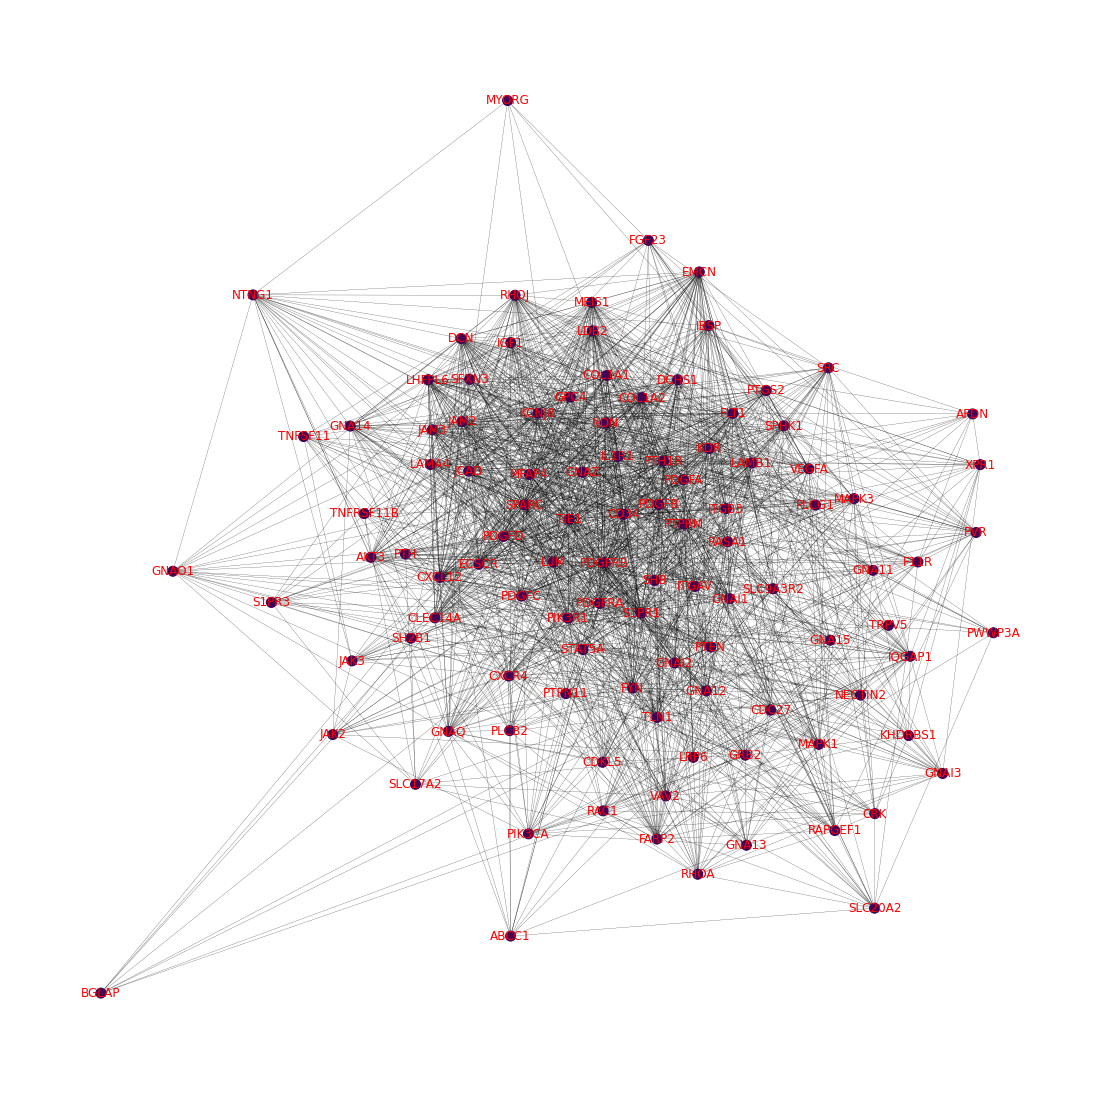

In [7]:
gene_nodes = network_mirdb['gene_symbol'].unique()
color_values = {}
for node in graph.nodes():
    color_values[node] = 0.8 if node in gene_nodes else 0.3
    
sizes_values = {}
for node in graph.nodes():
    sizes_values[node] = 100 if node in gene_nodes else 5
    
values = [color_values.get(node, 0.25) for node in graph.nodes()]
sizes = [sizes_values.get(node, 0.25) for node in graph.nodes()]
# weights = [mir_graph[u][v]['target_value'] for u,v in mir_graph.edges]
labels = {node_name: node_name if node_name in gene_nodes else '' for node_name in graph.nodes()}

plt.figure(figsize =(15, 15))
nx.draw(graph, cmap=plt.get_cmap('viridis'),
        labels=labels, node_color=values,
        node_size=sizes, width=0.2,
        with_labels=True, font_color='red')
plt.savefig('figures/genemania_networkx_plot.png')

##### Calculating centrality measures

In [8]:
close_centrality = nx.closeness_centrality(graph)
bet_centrality = nx.betweenness_centrality(graph, normalized = True, 
                                              endpoints = False)
deg_centrality = nx.degree_centrality(graph)

central_measures = pd.DataFrame()
central_measures['gene'] = bet_centrality.keys()
central_measures['betweenness_genemania'] = [val for val in bet_centrality.values()]
central_measures['degree_genemania'] = [val for val in deg_centrality.values()]
central_measures['closeness_genemania'] = [val for val in close_centrality.values()]

ranked = central_measures.sort_values(
    by='betweenness_genemania', ascending=False
    ).reset_index().drop('index', axis = 1)

ranked

gene  betweenness_genemania  degree_genemania  closeness_genemania
0    PDGFRB               0.032852          0.695238             0.766423
1    PIK3R1               0.018495          0.523810             0.677419
2     PTPRM               0.018012          0.561905             0.695364
3     S1PR1               0.017773          0.561905             0.695364
4      CD34               0.017298          0.552381             0.690789
..      ...                    ...               ...                  ...
101   S1PR3               0.000664          0.133333             0.527638
102   MYORG               0.000445          0.057143             0.464602
103  PWWP3A               0.000408          0.095238             0.507246
104   TRPV5               0.000337          0.057143             0.468750
105   BGLAP               0.000201          0.076190             0.492958

[106 rows x 4 columns]

In [9]:
ranked[ranked['gene'].isin(PFBC_GENES)]

gene  betweenness_genemania  degree_genemania  closeness_genemania
0     PDGFRB               0.032852          0.695238             0.766423
15     PDGFB               0.011344          0.390476             0.621302
54      JAM2               0.005103          0.485714             0.660377
87   SLC20A2               0.002402          0.171429             0.535714
88      XPR1               0.002339          0.180952             0.541237
102    MYORG               0.000445          0.057143             0.464602

##### Extracting neareast neighbors from the interactome graph

In [10]:
path_sources = {}
for gene in PFBC_GENES:
    full_paths = []
    full_length = 0
    queue = PFBC_GENES.copy()
    while len(queue) > 0:
        try:
            nearest_step, length, path = get_nearest(graph, gene, queue, 'weight')
            full_paths.extend(path)
            full_length += length
            queue.remove(nearest_step)     
        except TypeError:
            break
    
    path_sources[gene] = (full_length, full_paths)
path_sources[min(path_sources, key=path_sources.get)]

(0.00859292146,
 ['SLC20A2',
  'PTPRM',
  'PDGFB',
  'SLC20A2',
  'DCN',
  'XPR1',
  'SLC20A2',
  'MEIS1',
  'PDGFRB',
  'SLC20A2',
  'PTPRM',
  'PDGFRA',
  'JAM2',
  'SLC20A2',
  'PTPRM',
  'PDGFB',
  'MYORG'])

#### 4.2 miRDB graph by target value

#### Turning reflecting target values to correspond to the weight values negative node associations

In [11]:
network_mirdb['target_value_reflected'] = network_mirdb['target_value'].apply(reflect_num)

In [12]:
network_mirdb

mirna          gene  target_value gene_symbol  \
0      hsa-let-7a-2-3p     NM_003371      70.83460        VAV2   
1      hsa-let-7a-2-3p     NM_006749      82.34390     SLC20A2   
2      hsa-let-7a-2-3p  NM_001288718      57.99320      STAT5A   
3      hsa-let-7a-2-3p     NM_002037      61.62080         FYN   
4      hsa-let-7a-2-3p  NM_001134398      93.21992        VAV2   
...                ...           ...           ...         ...   
29442     hsa-miR-9985     NM_181524      57.34490      PIK3R1   
29443     hsa-miR-9985  NM_001242466      57.34490      PIK3R1   
29444     hsa-miR-9985     NM_203506      79.67020        GRB2   
29445     hsa-miR-9986     NM_016823      80.73640         CRK   
29446     hsa-miR-9986     NM_005206      91.59437         CRK   

       target_value_reflected  
0                       0.030  
1                       0.018  
2                       0.043  
3                       0.039  
4                       0.070  
...                       ...  
29442                   0.043  
29443                   0.043  
29444                   0.021  
29445                   0.020  
29446                   0.090  

[29447 rows x 5 columns]

In [13]:
len(network_mirdb['mirna'].unique())

2363

In [14]:
nx_df = network_mirdb[network_mirdb['target_value_reflected'] >= reflect_num(TARGET_THRESHOLD)]
mir_graph = nx.from_pandas_edgelist(nx_df, 'mirna', 'gene_symbol', edge_attr='target_value_reflected')

##### 4.2.1 Plotting graph

In [15]:
gene_nodes = network_mirdb['gene_symbol'].unique()
color_values = {}
for node in mir_graph.nodes():
    color_values[node] = 0.8 if node in gene_nodes else 0.3
    
sizes_values = {}
for node in mir_graph.nodes():
    sizes_values[node] = 100 if node in gene_nodes else 5

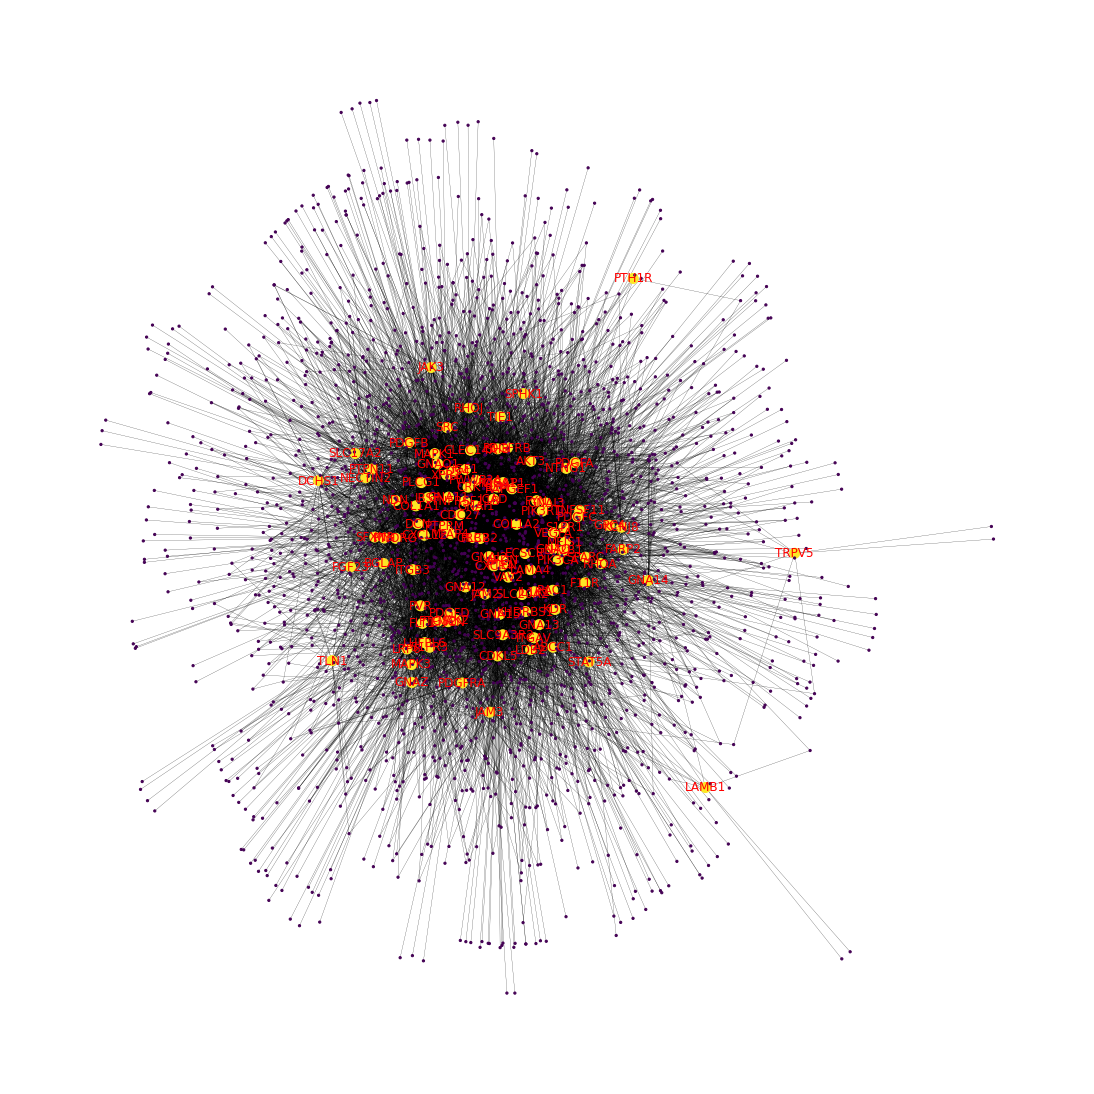

In [16]:
values = [color_values.get(node, 0.25) for node in mir_graph.nodes()]
sizes = [sizes_values.get(node, 0.25) for node in mir_graph.nodes()]
# weights = [mir_graph[u][v]['target_value'] for u,v in mir_graph.edges]
labels = {node_name: node_name if node_name in gene_nodes else '' for node_name in mir_graph.nodes()}

plt.figure(figsize =(15, 15))
nx.draw(mir_graph, cmap=plt.get_cmap('viridis'),
        labels=labels, node_color=values,
        node_size=sizes, width=0.2,
        with_labels=True, font_color='red')
plt.show()

##### 4.2.2 Showing only PFBC genes in the miR graph

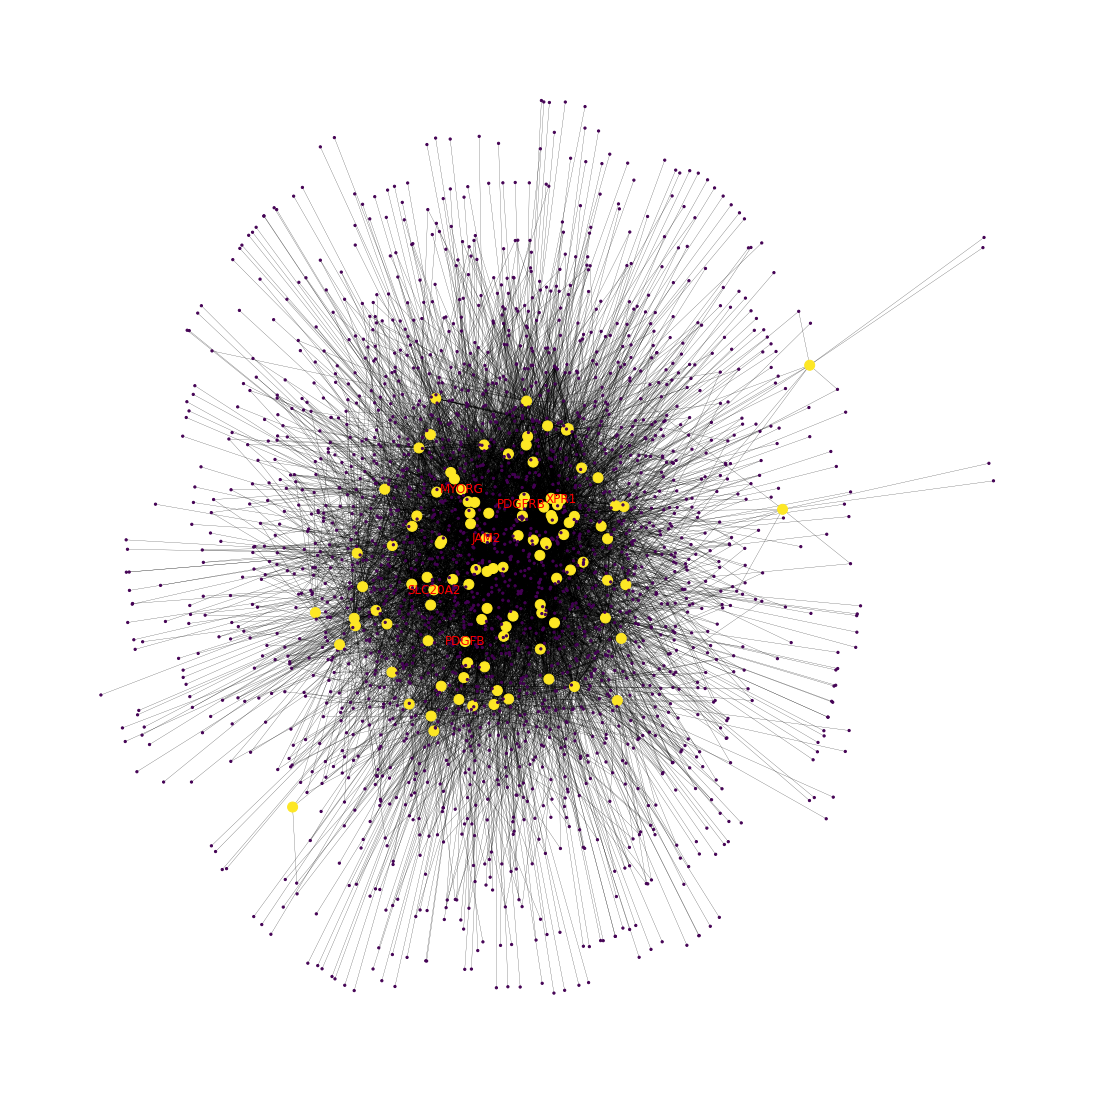

In [17]:
values = [color_values.get(node, 0.25) for node in mir_graph.nodes()]
sizes = [sizes_values.get(node, 0.25) for node in mir_graph.nodes()]
# weights = [mir_graph[u][v]['target_value'] for u,v in mir_graph.edges]
labels = {node_name: node_name if node_name in PFBC_GENES else '' for node_name in mir_graph.nodes()}

plt.figure(figsize =(15, 15))
nx.draw(mir_graph, cmap=plt.get_cmap('viridis'), labels=labels, node_color=values, node_size=sizes, width=0.2, with_labels=True, font_color='red')
plt.savefig('figures/mirdb_network.png')

##### 4.2.3 Centrality measures of miR graph

In [18]:
close_centrality = nx.closeness_centrality(mir_graph)
bet_centrality = nx.betweenness_centrality(mir_graph, normalized = True, 
                                              endpoints = False)
deg_centrality = nx.degree_centrality(mir_graph)

central_measures_mirdb = pd.DataFrame()
central_measures_mirdb['gene'] = bet_centrality.keys()
central_measures_mirdb['betweenness_mirdb'] = [val for val in bet_centrality.values()]
central_measures_mirdb['degree_mirdb'] = [val for val in deg_centrality.values()]
central_measures_mirdb['closeness_mirdb'] = [val for val in close_centrality.values()]

ranked = central_measures_mirdb.sort_values(
    by='betweenness_mirdb', ascending=False
    ).reset_index().drop('index', axis = 1)

ranked

gene  betweenness_mirdb  degree_mirdb  closeness_mirdb
0                  PTEN           0.084228      0.131557         0.371056
1                PIK3CA           0.066933      0.109137         0.364309
2                  IGF1           0.066622      0.112944         0.365322
3                  AKT3           0.065950      0.112944         0.364759
4                 CDKL5           0.064027      0.103638         0.363525
...                 ...                ...           ...              ...
2360       hsa-miR-1265           0.000000      0.000423         0.253105
2361    hsa-miR-6790-5p           0.000000      0.000423         0.257797
2362    hsa-miR-6789-5p           0.000000      0.000423         0.246250
2363  hsa-miR-550b-2-5p           0.000000      0.000423         0.251169
2364       hsa-miR-9986           0.000000      0.000423         0.258983

[2365 rows x 4 columns]

In [19]:
ranked = central_measures_mirdb.sort_values(
    by='betweenness_mirdb', ascending=False
    ).reset_index().drop('index', axis = 1)

In [20]:
ranked[ranked['gene'].isin(PFBC_GENES)]

gene  betweenness_mirdb  degree_mirdb  closeness_mirdb
8      XPR1           0.050470      0.085448         0.358671
22    MYORG           0.020830      0.049492         0.347392
28     JAM2           0.016987      0.046108         0.346577
40  SLC20A2           0.013832      0.040186         0.344456
58    PDGFB           0.009470      0.033418         0.342658
66   PDGFRB           0.008029      0.033418         0.341175

#### 4.3 Joining mirDB to the GeneMania data

In [21]:
from itertools import combinations

In [22]:
network_mirdb.head()

mirna          gene  target_value gene_symbol  \
0  hsa-let-7a-2-3p     NM_003371      70.83460        VAV2   
1  hsa-let-7a-2-3p     NM_006749      82.34390     SLC20A2   
2  hsa-let-7a-2-3p  NM_001288718      57.99320      STAT5A   
3  hsa-let-7a-2-3p     NM_002037      61.62080         FYN   
4  hsa-let-7a-2-3p  NM_001134398      93.21992        VAV2   

   target_value_reflected  
0                   0.030  
1                   0.018  
2                   0.043  
3                   0.039  
4                   0.070

In [23]:
interact.head()

g1       g2    weight  Network group                  source
0  PDGFRB  SLC20A2  0.021015  Co-expression  Mullighan-Downing-2009
1     KDR     JAM3  0.009146  Co-expression  Mullighan-Downing-2009
2    GNAZ     JAM2  0.018249  Co-expression  Mullighan-Downing-2009
3   MAPK3    GNAI2  0.007586  Co-expression  Mullighan-Downing-2009
4    RHOA    GNAI3  0.013042  Co-expression  Mullighan-Downing-2009

### Extraing genes pair-wise average miR predicted target values

In [24]:
mir_average_values = []
for mir in network_mirdb['mirna'].unique():
    sub_df = network_mirdb[network_mirdb['mirna'] == mir]
    mir_genes = sub_df['gene_symbol'].unique()
    mir_gene_pairs = combinations(mir_genes, 2)
    for gene_pair in mir_gene_pairs:
        av_val = (
            (sub_df[sub_df['gene_symbol'] == gene_pair[0]]['target_value'].max() 
             + sub_df[sub_df['gene_symbol'] == gene_pair[1]]['target_value'].max())
            / 2)
        mir_average_values.append((gene_pair[0], gene_pair[1], mir, av_val))

In [25]:
mir_average_values

[('VAV2', 'SLC20A2', 'hsa-let-7a-2-3p', 94.04706999999999),
 ('VAV2', 'STAT5A', 'hsa-let-7a-2-3p', 75.60656),
 ('VAV2', 'FYN', 'hsa-let-7a-2-3p', 77.42036),
 ('VAV2', 'GPC4', 'hsa-let-7a-2-3p', 77.10601),
 ('VAV2', 'RAC1', 'hsa-let-7a-2-3p', 74.7657013066),
 ('VAV2', 'TNFSF11', 'hsa-let-7a-2-3p', 92.776805),
 ('VAV2', 'PDGFRA', 'hsa-let-7a-2-3p', 91.0235714823),
 ('SLC20A2', 'STAT5A', 'hsa-let-7a-2-3p', 76.43370999999999),
 ('SLC20A2', 'FYN', 'hsa-let-7a-2-3p', 78.24751),
 ('SLC20A2', 'GPC4', 'hsa-let-7a-2-3p', 77.93316),
 ('SLC20A2', 'RAC1', 'hsa-let-7a-2-3p', 75.5928513066),
 ('SLC20A2', 'TNFSF11', 'hsa-let-7a-2-3p', 93.603955),
 ('SLC20A2', 'PDGFRA', 'hsa-let-7a-2-3p', 91.8507214823),
 ('STAT5A', 'FYN', 'hsa-let-7a-2-3p', 59.807),
 ('STAT5A', 'GPC4', 'hsa-let-7a-2-3p', 59.49265),
 ('STAT5A', 'RAC1', 'hsa-let-7a-2-3p', 57.1523413066),
 ('STAT5A', 'TNFSF11', 'hsa-let-7a-2-3p', 75.163445),
 ('STAT5A', 'PDGFRA', 'hsa-let-7a-2-3p', 73.4102114823),
 ('FYN', 'GPC4', 'hsa-let-7a-2-3p', 61.3

#### Saving data to a DataFrame

In [26]:
mir_pair_df = pd.DataFrame(mir_average_values, columns = ['g1', 'g2', 'mirna', 'target_value'])

In [27]:
mir_pair_df['target_value_reflected'] = mir_pair_df['target_value'].apply(reflect_num)

In [28]:
#mir_pair_df.to_csv('mir_pair_df.csv', index=False)

In [29]:
mir_pair_df.head()

g1       g2            mirna  target_value  target_value_reflected
0  VAV2  SLC20A2  hsa-let-7a-2-3p     94.047070                   0.060
1  VAV2   STAT5A  hsa-let-7a-2-3p     75.606560                   0.025
2  VAV2      FYN  hsa-let-7a-2-3p     77.420360                   0.023
3  VAV2     GPC4  hsa-let-7a-2-3p     77.106010                   0.023
4  VAV2     RAC1  hsa-let-7a-2-3p     74.765701                   0.026

#### Joining miR with average pair-wise target values to GeneMania data

In [30]:
joint_df = interact.merge(mir_pair_df, left_on = ['g1', 'g2'], right_on = ['g1', 'g2'], how='outer')

In [31]:
joint_df.head()

g1       g2    weight  Network group                  source mirna  \
0  PDGFRB  SLC20A2  0.021015  Co-expression  Mullighan-Downing-2009   NaN   
1  PDGFRB  SLC20A2  0.005637  Co-expression         Finak-Park-2008   NaN   
2  PDGFRB  SLC20A2  0.009642  Co-expression   Detweiler-Falkow-2001   NaN   
3  PDGFRB  SLC20A2  0.006267  Co-expression      Newman-Radeke-2012   NaN   
4     KDR     JAM3  0.009146  Co-expression  Mullighan-Downing-2009   NaN   

   target_value  target_value_reflected  
0           NaN                     NaN  
1           NaN                     NaN  
2           NaN                     NaN  
3           NaN                     NaN  
4           NaN                     NaN

In [32]:
joint_df['target_value'].fillna(0, inplace=True)
joint_df['target_value_reflected'].fillna(1, inplace=True)
joint_df['weight'].fillna(2, inplace=True)

In [33]:
#joint_df.to_csv('interact_with_mirna_pair_outer_reflected.csv', index=False)

#### Creating new joint miR graph

In [34]:
nx_df = joint_df[joint_df['target_value_reflected'] < reflect_num(TARGET_THRESHOLD)]
mir_graph = nx.from_pandas_edgelist(nx_df, 'g1', 'g2', edge_attr=['weight', 'mirna', 'target_value_reflected'])

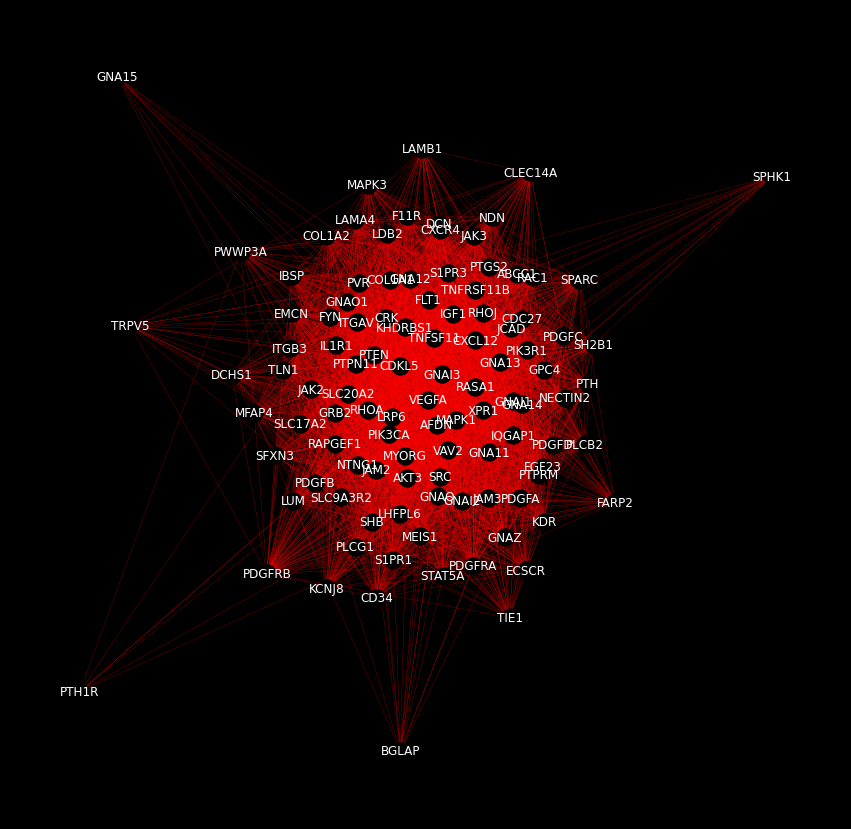

In [35]:
fig, ax = plt.subplots(figsize = (15,15))

nx.draw(mir_graph, cmap=plt.get_cmap('viridis'), width=0.2, with_labels=True, node_color='black', edge_color='red', font_color='white')
ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')

plt.show()

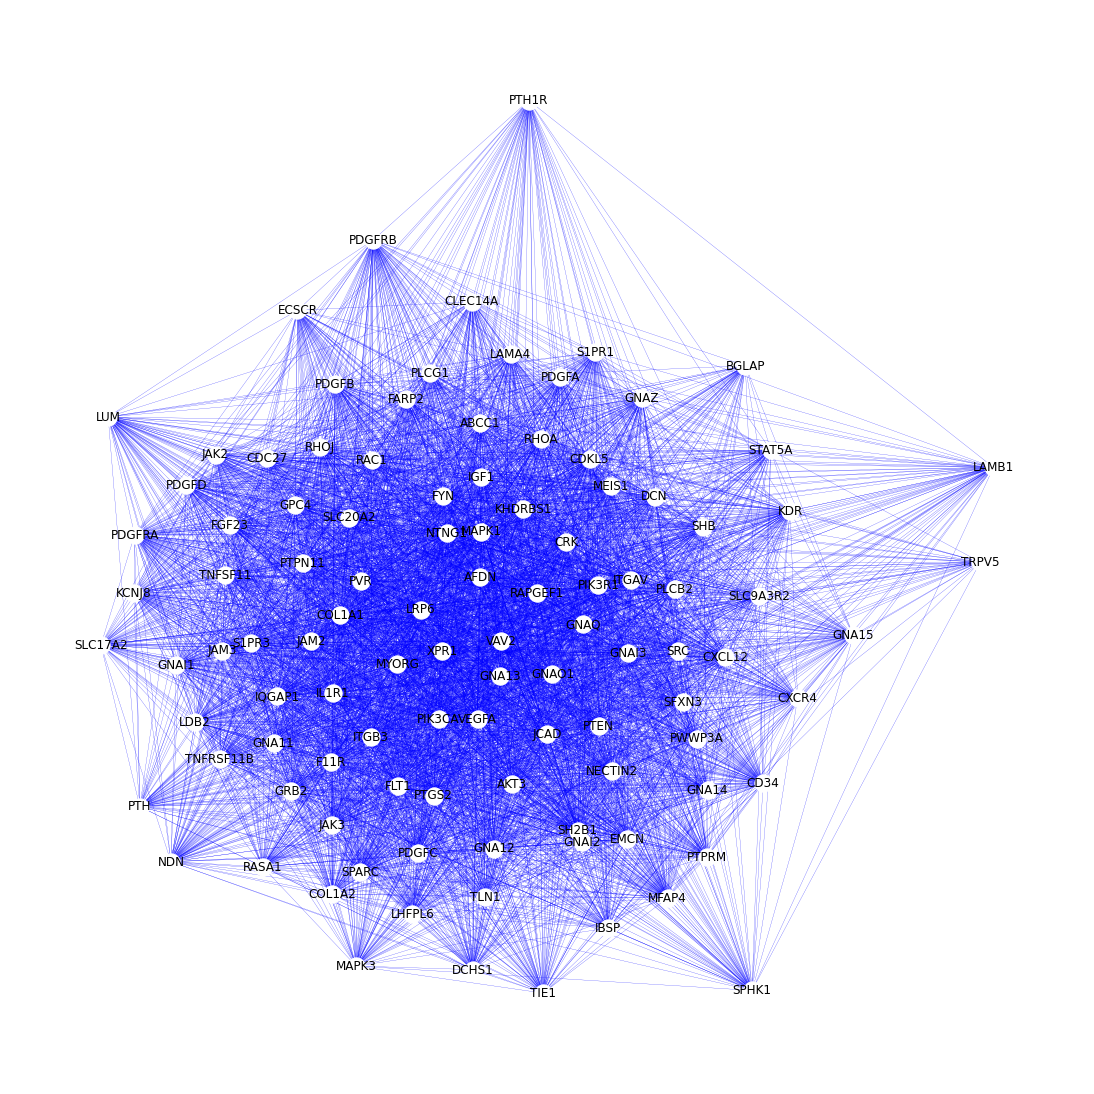

In [36]:
nx_df = joint_df[joint_df['target_value'] < TARGET_THRESHOLD]
mir_graph_target = nx.from_pandas_edgelist(nx_df[['g1', 'g2', 'weight', 'mirna', 'target_value']], 'g1', 'g2', edge_attr=['weight', 'mirna', 'target_value'])
plt.figure(figsize =(15, 15))
nx.draw(mir_graph_target, node_color = 'white', edge_color = 'blue', width=0.2, with_labels=True, font_color='black')
plt.savefig('figures/genemania_mirdb_network.png')

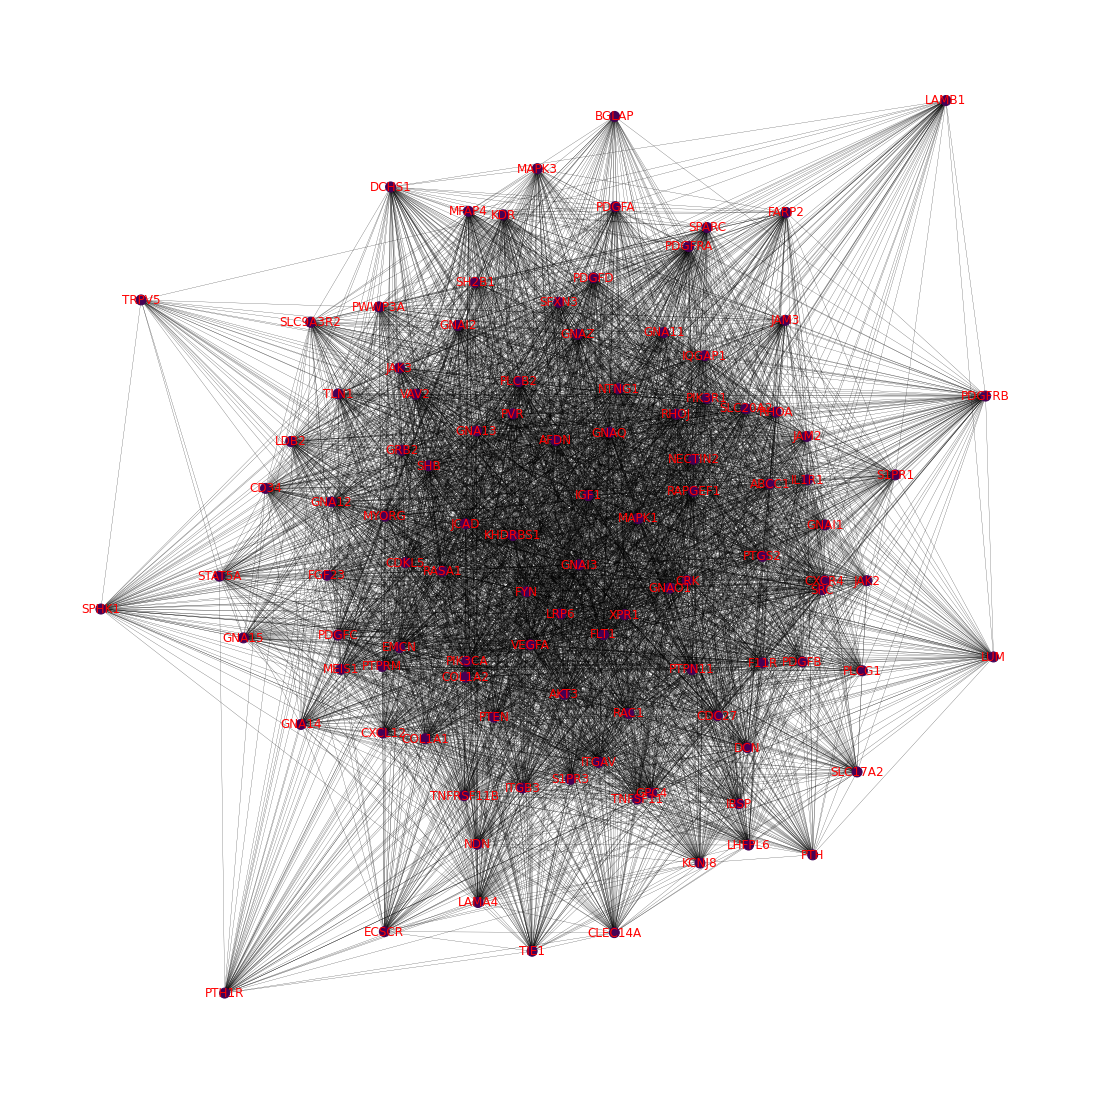

In [37]:
mir_graph_target = nx.from_pandas_edgelist(nx_df[['g1', 'g2', 'weight', 'mirna', 'target_value_reflected']], 'g1', 'g2', edge_attr=['weight', 'mirna', 'target_value_reflected'])

color_values = {}
for node in mir_graph_target.nodes():
    color_values[node] = 0.8 if node in gene_nodes else 0.3
    
sizes_values = {}
for node in mir_graph_target.nodes():
    sizes_values[node] = 100 if node in gene_nodes else 5
    
values = [color_values.get(node, 0.25) for node in mir_graph_target.nodes()]
sizes = [sizes_values.get(node, 0.25) for node in mir_graph_target.nodes()]
# weights = [mir_graph[u][v]['target_value'] for u,v in mir_graph.edges]
labels = {node_name: node_name if node_name in gene_nodes else '' for node_name in mir_graph_target.nodes()}

plt.figure(figsize =(15, 15))
nx.draw(mir_graph_target, cmap=plt.get_cmap('viridis'),
        labels=labels, node_color=values,
        node_size=sizes, width=0.2,
        with_labels=True, font_color='red')
plt.savefig('figures/joint_networkx_plot.png')

#### Calculating centrality measurements

In [38]:
close_centrality = nx.closeness_centrality(mir_graph)
bet_centrality = nx.betweenness_centrality(mir_graph, normalized = True, 
                                              endpoints = False)
deg_centrality = nx.degree_centrality(mir_graph)

central_measures_joint = pd.DataFrame()
central_measures_joint['gene'] = bet_centrality.keys()
central_measures_joint['betweenness_joint'] = [val for val in bet_centrality.values()]
central_measures_joint['degree_joint'] = [val for val in deg_centrality.values()]
central_measures_joint['closeness_joint'] = [val for val in close_centrality.values()]

central_measures_joint

gene  betweenness_joint  degree_joint  closeness_joint
0     RHOA           0.004669      0.885714         0.897436
1    GNAI3           0.008922      0.914286         0.921053
2    GNAI1           0.003379      0.895238         0.905172
3    FGF23           0.001174      0.733333         0.789474
4      SHB           0.003996      0.847619         0.867769
..     ...                ...           ...              ...
101  SFXN3           0.000738      0.580952         0.704698
102  PTH1R           0.000016      0.066667         0.517241
103  MYORG           0.003191      0.866667         0.882353
104  TRPV5           0.000095      0.209524         0.558511
105  BGLAP           0.000046      0.161905         0.544041

[106 rows x 4 columns]

In [39]:
central_measures_joint.sort_values(by='betweenness_joint', ascending=False).head(10)

gene  betweenness_joint  degree_joint  closeness_joint
1    GNAI3           0.008922      0.914286         0.921053
32   NTNG1           0.007063      0.952381         0.954545
52    IGF1           0.006933      0.961905         0.963303
92    LRP6           0.006382      0.942857         0.945946
17    AKT3           0.005461      0.961905         0.963303
27   MAPK1           0.005202      0.933333         0.937500
35   ITGAV           0.005065      0.942857         0.945946
85   GNAO1           0.004849      0.885714         0.897436
39  LHFPL6           0.004846      0.857143         0.875000
16  PIK3R1           0.004777      0.952381         0.954545

In [40]:
central_measures_joint.sort_values(by='degree_joint', ascending=False).head(10)

gene  betweenness_joint  degree_joint  closeness_joint
52    IGF1           0.006933      0.961905         0.963303
17    AKT3           0.005461      0.961905         0.963303
16  PIK3R1           0.004777      0.952381         0.954545
32   NTNG1           0.007063      0.952381         0.954545
92    LRP6           0.006382      0.942857         0.945946
35   ITGAV           0.005065      0.942857         0.945946
68    PTEN           0.003992      0.933333         0.937500
31  PIK3CA           0.003804      0.933333         0.937500
26   GNA13           0.004388      0.933333         0.937500
27   MAPK1           0.005202      0.933333         0.937500

In [41]:
central_measures_joint.sort_values(by='closeness_joint', ascending=False).head(10)

gene  betweenness_joint  degree_joint  closeness_joint
52    IGF1           0.006933      0.961905         0.963303
17    AKT3           0.005461      0.961905         0.963303
16  PIK3R1           0.004777      0.952381         0.954545
32   NTNG1           0.007063      0.952381         0.954545
92    LRP6           0.006382      0.942857         0.945946
35   ITGAV           0.005065      0.942857         0.945946
68    PTEN           0.003992      0.933333         0.937500
31  PIK3CA           0.003804      0.933333         0.937500
26   GNA13           0.004388      0.933333         0.937500
27   MAPK1           0.005202      0.933333         0.937500

In [42]:
ranked = central_measures_joint.sort_values(
    by='degree_joint', ascending=False
    ).reset_index().drop('index', axis = 1)

In [43]:
ranked[ranked['gene'].isin(PFBC_GENES)]

gene  betweenness_joint  degree_joint  closeness_joint
15     XPR1           0.003865      0.914286         0.921053
29    MYORG           0.003191      0.866667         0.882353
47     JAM2           0.002822      0.819048         0.846774
52  SLC20A2           0.001698      0.800000         0.833333
54    PDGFB           0.003644      0.800000         0.833333
56   PDGFRB           0.002505      0.790476         0.826772

#### Joining all three graph centrality measures

In [44]:
central_measures = central_measures.merge(central_measures_mirdb, on='gene')
central_measures = central_measures.merge(central_measures_joint, on='gene')

In [45]:
central_measures

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0     PDGFRB               0.032852          0.695238             0.766423   
1    SLC20A2               0.002402          0.171429             0.535714   
2        KDR               0.011565          0.523810             0.677419   
3       JAM3               0.005728          0.495238             0.664557   
4       GNAZ               0.008300          0.323810             0.596591   
..       ...                    ...               ...                  ...   
101     AFDN               0.000933          0.114286             0.517241   
102     LRP6               0.003855          0.171429             0.544041   
103  TNFSF11               0.001447          0.152381             0.532995   
104    TRPV5               0.000337          0.057143             0.468750   
105    BGLAP               0.000201          0.076190             0.492958   

     betweenness_mirdb  degree_mirdb  closeness_mirdb  betweenness_joint  \
0             0.008029      0.033418         0.341175           0.002505   
1             0.013832      0.040186         0.344456           0.001698   
2             0.006002      0.024958         0.335272           0.001936   
3             0.006932      0.023689         0.335272           0.001104   
4             0.005143      0.016920         0.335367           0.002380   
..                 ...           ...              ...                ...   
101           0.023787      0.061337         0.350274           0.003781   
102           0.041897      0.078257         0.355649           0.006382   
103           0.008838      0.035533         0.341668           0.002795   
104           0.001893      0.003807         0.274916           0.000095   
105           0.000336      0.007191         0.307452           0.000046   

     degree_joint  closeness_joint  
0        0.790476         0.826772  
1        0.800000         0.833333  
2        0.847619         0.867769  
3        0.723810         0.783582  
4        0.742857         0.795455  
..            ...              ...  
101      0.914286         0.921053  
102      0.942857         0.945946  
103      0.838095         0.860656  
104      0.209524         0.558511  
105      0.161905         0.544041  

[106 rows x 10 columns]

In [46]:
pd.options.display.max_rows = 999

In [47]:
bet_rank = central_measures.sort_values(by=['betweenness_genemania', 'betweenness_mirdb', 'betweenness_joint'], ascending=False).reset_index().drop('index', axis = 1)

In [48]:
bet_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0       PDGFRB               0.032852          0.695238             0.766423   
1       PIK3R1               0.018495          0.523810             0.677419   
2        PTPRM               0.018012          0.561905             0.695364   
3        S1PR1               0.017773          0.561905             0.695364   
4         CD34               0.017298          0.552381             0.690789   
5        PTH1R               0.016532          0.476190             0.656250   
6         FLT1               0.015562          0.485714             0.660377   
7        SPARC               0.014666          0.590476             0.709459   
8       COL1A2               0.013895          0.514286             0.673077   
9        GNAI2               0.013841          0.428571             0.636364   
10        GRB2               0.012907          0.342857             0.603448   
11      PDGFRA               0.012686          0.533333             0.681818   
12         LUM               0.012432          0.533333             0.677419   
13         KDR               0.011565          0.523810             0.677419   
14       GNAI1               0.011510          0.447619             0.640244   
15       PDGFB               0.011344          0.390476             0.621302   
16      LHFPL6               0.011289          0.533333             0.681818   
17         FYN               0.011227          0.428571             0.636364   
18       PDGFC               0.010817          0.428571             0.636364   
19        EMCN               0.010612          0.514286             0.673077   
20       VEGFA               0.010292          0.361905             0.610465   
21      CXCL12               0.009774          0.523810             0.677419   
22       LAMB1               0.009774          0.485714             0.660377   
23      STAT5A               0.009713          0.295238             0.586592   
24       CXCR4               0.009618          0.371429             0.614035   
25         DCN               0.009568          0.533333             0.681818   
26       ITGAV               0.009278          0.409524             0.621302   
27       GNA12               0.009164          0.342857             0.603448   
28       MAPK3               0.008953          0.304762             0.589888   
29       FARP2               0.008860          0.352381             0.603448   
30       KCNJ8               0.008813          0.466667             0.652174   
31        LDB2               0.008610          0.523810             0.677419   
32       ITGB3               0.008459          0.390476             0.621302   
33        VAV2               0.008368          0.266667             0.576923   
34       MEIS1               0.008331          0.485714             0.656250   
35        GNAZ               0.008300          0.323810             0.596591   
36       NTNG1               0.007968          0.247619             0.567568   
37      IQGAP1               0.007531          0.361905             0.610465   
38        TLN1               0.007470          0.352381             0.606936   
39       PTGS2               0.006681          0.361905             0.610465   
40       LAMA4               0.006464          0.457143             0.648148   
41         SRC               0.006324          0.285714             0.576923   
42       MAPK1               0.006310          0.304762             0.586592   
43    SLC9A3R2               0.006214          0.247619             0.567568   
44        GNAQ               0.006188          0.323810             0.596591   
45        GPC4               0.006150          0.323810             0.596591   
46        IBSP               0.006066          0.285714             0.583333   
47       RASA1               0.006043          0.352381             0.606936   
48         SHB               0.006002          0.257143             0.573770   
49       S

In [49]:
deg_rank = central_measures.sort_values(by=['degree_genemania', 'degree_mirdb', 'degree_joint'], ascending=False).reset_index().drop('index', axis = 1)

In [50]:
deg_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0       PDGFRB               0.032852          0.695238             0.766423   
1        SPARC               0.014666          0.590476             0.709459   
2        S1PR1               0.017773          0.561905             0.695364   
3        PTPRM               0.018012          0.561905             0.695364   
4         CD34               0.017298          0.552381             0.690789   
5       PDGFRA               0.012686          0.533333             0.681818   
6          DCN               0.009568          0.533333             0.681818   
7       LHFPL6               0.011289          0.533333             0.681818   
8          LUM               0.012432          0.533333             0.677419   
9       PIK3R1               0.018495          0.523810             0.677419   
10      CXCL12               0.009774          0.523810             0.677419   
11        LDB2               0.008610          0.523810             0.677419   
12         KDR               0.011565          0.523810             0.677419   
13        EMCN               0.010612          0.514286             0.673077   
14      COL1A2               0.013895          0.514286             0.673077   
15        JAM3               0.005728          0.495238             0.664557   
16        FLT1               0.015562          0.485714             0.660377   
17        JAM2               0.005103          0.485714             0.660377   
18       MEIS1               0.008331          0.485714             0.656250   
19       LAMB1               0.009774          0.485714             0.660377   
20       PTH1R               0.016532          0.476190             0.656250   
21        RHOJ               0.005552          0.466667             0.652174   
22       KCNJ8               0.008813          0.466667             0.652174   
23       MFAP4               0.004875          0.457143             0.648148   
24       LAMA4               0.006464          0.457143             0.648148   
25       GNAI1               0.011510          0.447619             0.640244   
26         NDN               0.004932          0.438095             0.636364   
27         FYN               0.011227          0.428571             0.636364   
28       PDGFD               0.005380          0.428571             0.628743   
29       GNAI2               0.013841          0.428571             0.636364   
30       PDGFC               0.010817          0.428571             0.636364   
31        JCAD               0.002777          0.419048             0.632530   
32        TIE1               0.003472          0.419048             0.632530   
33       ITGAV               0.009278          0.409524             0.621302   
34     CLEC14A               0.003640          0.409524             0.628743   
35       DCHS1               0.003918          0.400000             0.621302   
36       ECSCR               0.002952          0.400000             0.625000   
37       ITGB3               0.008459          0.390476             0.621302   
38       PDGFB               0.011344          0.390476             0.621302   
39        AKT3               0.004410          0.371429             0.610465   
40       PDGFA               0.003831          0.371429             0.614035   
41       CXCR4               0.009618          0.371429             0.614035   
42       VEGFA               0.010292          0.361905             0.610465   
43       IL1R1               0.003122          0.361905             0.606936   
44       PTGS2               0.006681          0.361905             0.610465   
45      IQGAP1               0.007531          0.361905             0.610465   
46        IGF1               0.003792          0.352381             0.603448   
47       RASA1               0.006043          0.352381             0.606936   
48        TLN1               0.007470          0.352381             0.606936   
49       F

In [51]:
clo_rank = central_measures.sort_values(by=['closeness_genemania', 'closeness_mirdb', 'closeness_joint'], ascending=False).reset_index().drop('index', axis = 1)
clo_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0       PDGFRB               0.032852          0.695238             0.766423   
1        SPARC               0.014666          0.590476             0.709459   
2        S1PR1               0.017773          0.561905             0.695364   
3        PTPRM               0.018012          0.561905             0.695364   
4         CD34               0.017298          0.552381             0.690789   
5       PDGFRA               0.012686          0.533333             0.681818   
6          DCN               0.009568          0.533333             0.681818   
7       LHFPL6               0.011289          0.533333             0.681818   
8       PIK3R1               0.018495          0.523810             0.677419   
9       CXCL12               0.009774          0.523810             0.677419   
10        LDB2               0.008610          0.523810             0.677419   
11         KDR               0.011565          0.523810             0.677419   
12         LUM               0.012432          0.533333             0.677419   
13        EMCN               0.010612          0.514286             0.673077   
14      COL1A2               0.013895          0.514286             0.673077   
15        JAM3               0.005728          0.495238             0.664557   
16        FLT1               0.015562          0.485714             0.660377   
17        JAM2               0.005103          0.485714             0.660377   
18       LAMB1               0.009774          0.485714             0.660377   
19       MEIS1               0.008331          0.485714             0.656250   
20       PTH1R               0.016532          0.476190             0.656250   
21        RHOJ               0.005552          0.466667             0.652174   
22       KCNJ8               0.008813          0.466667             0.652174   
23       LAMA4               0.006464          0.457143             0.648148   
24       MFAP4               0.004875          0.457143             0.648148   
25       GNAI1               0.011510          0.447619             0.640244   
26         FYN               0.011227          0.428571             0.636364   
27       GNAI2               0.013841          0.428571             0.636364   
28       PDGFC               0.010817          0.428571             0.636364   
29         NDN               0.004932          0.438095             0.636364   
30        JCAD               0.002777          0.419048             0.632530   
31        TIE1               0.003472          0.419048             0.632530   
32       PDGFD               0.005380          0.428571             0.628743   
33     CLEC14A               0.003640          0.409524             0.628743   
34       ECSCR               0.002952          0.400000             0.625000   
35       ITGAV               0.009278          0.409524             0.621302   
36       ITGB3               0.008459          0.390476             0.621302   
37       PDGFB               0.011344          0.390476             0.621302   
38       DCHS1               0.003918          0.400000             0.621302   
39       PDGFA               0.003831          0.371429             0.614035   
40       CXCR4               0.009618          0.371429             0.614035   
41        AKT3               0.004410          0.371429             0.610465   
42       VEGFA               0.010292          0.361905             0.610465   
43       PTGS2               0.006681          0.361905             0.610465   
44      IQGAP1               0.007531          0.361905             0.610465   
45       IL1R1               0.003122          0.361905             0.606936   
46       RASA1               0.006043          0.352381             0.606936   
47        TLN1               0.007470          0.352381             0.606936   
48       SPHK1               0.005982          0.352381             0.606936   
49        

### Ranking by joint

In [52]:
bet_rank = central_measures.sort_values(by=['betweenness_joint', 'betweenness_genemania', 'betweenness_mirdb'], ascending=False).reset_index().drop('index', axis = 1)
deg_rank = central_measures.sort_values(by=['degree_joint', 'degree_genemania', 'degree_mirdb'], ascending=False).reset_index().drop('index', axis = 1)
clo_rank = central_measures.sort_values(by=['closeness_joint', 'closeness_genemania', 'closeness_mirdb'], ascending=False).reset_index().drop('index', axis = 1)

In [53]:
bet_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0        GNAI3               0.002402          0.209524             0.552632   
1        NTNG1               0.007968          0.247619             0.567568   
2         IGF1               0.003792          0.352381             0.603448   
3         LRP6               0.003855          0.171429             0.544041   
4         AKT3               0.004410          0.371429             0.610465   
5        MAPK1               0.006310          0.304762             0.586592   
6        ITGAV               0.009278          0.409524             0.621302   
7        GNAO1               0.002683          0.180952             0.549738   
8       LHFPL6               0.011289          0.533333             0.681818   
9       PIK3R1               0.018495          0.523810             0.677419   
10        RHOA               0.003100          0.228571             0.558511   
11     KHDRBS1               0.000765          0.133333             0.525000   
12       MEIS1               0.008331          0.485714             0.656250   
13        LDB2               0.008610          0.523810             0.677419   
14       GNA13               0.003694          0.190476             0.549738   
15         SHB               0.006002          0.257143             0.573770   
16        PTEN               0.003684          0.304762             0.589888   
17        JCAD               0.002777          0.419048             0.632530   
18       VEGFA               0.010292          0.361905             0.610465   
19        XPR1               0.002339          0.180952             0.541237   
20      PIK3CA               0.002291          0.219048             0.555556   
21        AFDN               0.000933          0.114286             0.517241   
22       PDGFB               0.011344          0.390476             0.621302   
23        RHOJ               0.005552          0.466667             0.652174   
24        JAK2               0.001331          0.133333             0.530303   
25       GNAI1               0.011510          0.447619             0.640244   
26        VAV2               0.008368          0.266667             0.576923   
27     RAPGEF1               0.003063          0.219048             0.561497   
28      COL1A1               0.003385          0.342857             0.600000   
29        GNAQ               0.006188          0.323810             0.596591   
30       MYORG               0.000445          0.057143             0.464602   
31     SLC17A2               0.003160          0.123810             0.517241   
32      CXCL12               0.009774          0.523810             0.677419   
33       PTGS2               0.006681          0.361905             0.610465   
34         SRC               0.006324          0.285714             0.576923   
35       ABCC1               0.001037          0.123810             0.519802   
36         FYN               0.011227          0.428571             0.636364   
37      COL1A2               0.013895          0.514286             0.673077   
38        FLT1               0.015562          0.485714             0.660377   
39        JAM2               0.005103          0.485714             0.660377   
40       RASA1               0.006043          0.352381             0.606936   
41      PDGFRA               0.012686          0.533333             0.681818   
42     TNFSF11               0.001447          0.152381             0.532995   
43       CDKL5               0.002835          0.228571             0.561497   
44       GNAI2               0.013841          0.428571             0.636364   
45      PDGFRB               0.032852          0.695238             0.766423   
46        GPC4               0.006150          0.323810             0.596591   
47        GNAZ               0.008300          0.323810             0.596591   
48         DCN               0.009568          0.533333             0.681818   
49       S

In [54]:
deg_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0         AKT3               0.004410          0.371429             0.610465   
1         IGF1               0.003792          0.352381             0.603448   
2       PIK3R1               0.018495          0.523810             0.677419   
3        NTNG1               0.007968          0.247619             0.567568   
4        ITGAV               0.009278          0.409524             0.621302   
5         LRP6               0.003855          0.171429             0.544041   
6         PTEN               0.003684          0.304762             0.589888   
7        MAPK1               0.006310          0.304762             0.586592   
8       PIK3CA               0.002291          0.219048             0.555556   
9        GNA13               0.003694          0.190476             0.549738   
10        JCAD               0.002777          0.419048             0.632530   
11       VEGFA               0.010292          0.361905             0.610465   
12     KHDRBS1               0.000765          0.133333             0.525000   
13       GNAI3               0.002402          0.209524             0.552632   
14        XPR1               0.002339          0.180952             0.541237   
15        AFDN               0.000933          0.114286             0.517241   
16      CXCL12               0.009774          0.523810             0.677419   
17        GNAQ               0.006188          0.323810             0.596591   
18     RAPGEF1               0.003063          0.219048             0.561497   
19        FLT1               0.015562          0.485714             0.660377   
20       GNAI1               0.011510          0.447619             0.640244   
21       RASA1               0.006043          0.352381             0.606936   
22       CDKL5               0.002835          0.228571             0.561497   
23        RHOA               0.003100          0.228571             0.558511   
24       GNAO1               0.002683          0.180952             0.549738   
25      PDGFRA               0.012686          0.533333             0.681818   
26       PTGS2               0.006681          0.361905             0.610465   
27      COL1A1               0.003385          0.342857             0.600000   
28      PTPN11               0.004071          0.257143             0.570652   
29        GPC4               0.006150          0.323810             0.596591   
30       MYORG               0.000445          0.057143             0.464602   
31      LHFPL6               0.011289          0.533333             0.681818   
32         FYN               0.011227          0.428571             0.636364   
33        VAV2               0.008368          0.266667             0.576923   
34         KDR               0.011565          0.523810             0.677419   
35        GRB2               0.012907          0.342857             0.603448   
36         SHB               0.006002          0.257143             0.573770   
37        RHOJ               0.005552          0.466667             0.652174   
38       IL1R1               0.003122          0.361905             0.606936   
39       CDC27               0.002404          0.209524             0.555556   
40         CRK               0.002849          0.180952             0.544041   
41     TNFSF11               0.001447          0.152381             0.532995   
42   TNFRSF11B               0.002012          0.152381             0.532995   
43       S1PR1               0.017773          0.561905             0.695364   
44         DCN               0.009568          0.533333             0.681818   
45        JAK2               0.001331          0.133333             0.530303   
46        LDB2               0.008610          0.523810             0.677419   
47        JAM2               0.005103          0.485714             0.660377   
48       PDGFD               0.005380          0.428571             0.628743   
49       A

In [55]:
clo_rank

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
0         AKT3               0.004410          0.371429             0.610465   
1         IGF1               0.003792          0.352381             0.603448   
2       PIK3R1               0.018495          0.523810             0.677419   
3        NTNG1               0.007968          0.247619             0.567568   
4        ITGAV               0.009278          0.409524             0.621302   
5         LRP6               0.003855          0.171429             0.544041   
6         PTEN               0.003684          0.304762             0.589888   
7        MAPK1               0.006310          0.304762             0.586592   
8       PIK3CA               0.002291          0.219048             0.555556   
9        GNA13               0.003694          0.190476             0.549738   
10        JCAD               0.002777          0.419048             0.632530   
11       VEGFA               0.010292          0.361905             0.610465   
12     KHDRBS1               0.000765          0.133333             0.525000   
13       GNAI3               0.002402          0.209524             0.552632   
14        XPR1               0.002339          0.180952             0.541237   
15        AFDN               0.000933          0.114286             0.517241   
16      CXCL12               0.009774          0.523810             0.677419   
17        GNAQ               0.006188          0.323810             0.596591   
18     RAPGEF1               0.003063          0.219048             0.561497   
19        FLT1               0.015562          0.485714             0.660377   
20       GNAI1               0.011510          0.447619             0.640244   
21       RASA1               0.006043          0.352381             0.606936   
22       CDKL5               0.002835          0.228571             0.561497   
23        RHOA               0.003100          0.228571             0.558511   
24       GNAO1               0.002683          0.180952             0.549738   
25      PDGFRA               0.012686          0.533333             0.681818   
26       PTGS2               0.006681          0.361905             0.610465   
27      COL1A1               0.003385          0.342857             0.600000   
28      PTPN11               0.004071          0.257143             0.570652   
29        GPC4               0.006150          0.323810             0.596591   
30       MYORG               0.000445          0.057143             0.464602   
31      LHFPL6               0.011289          0.533333             0.681818   
32         FYN               0.011227          0.428571             0.636364   
33        VAV2               0.008368          0.266667             0.576923   
34         KDR               0.011565          0.523810             0.677419   
35        GRB2               0.012907          0.342857             0.603448   
36         SHB               0.006002          0.257143             0.573770   
37        RHOJ               0.005552          0.466667             0.652174   
38       IL1R1               0.003122          0.361905             0.606936   
39       CDC27               0.002404          0.209524             0.555556   
40         CRK               0.002849          0.180952             0.544041   
41     TNFSF11               0.001447          0.152381             0.532995   
42   TNFRSF11B               0.002012          0.152381             0.532995   
43       S1PR1               0.017773          0.561905             0.695364   
44         DCN               0.009568          0.533333             0.681818   
45        JAK2               0.001331          0.133333             0.530303   
46        LDB2               0.008610          0.523810             0.677419   
47        JAM2               0.005103          0.485714             0.660377   
48       PDGFD               0.005380          0.428571             0.628743   
49       A

In [56]:
deg_rank[deg_rank['gene'].isin(PFBC_GENES)]

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
14     XPR1               0.002339          0.180952             0.541237   
30    MYORG               0.000445          0.057143             0.464602   
47     JAM2               0.005103          0.485714             0.660377   
52    PDGFB               0.011344          0.390476             0.621302   
55  SLC20A2               0.002402          0.171429             0.535714   
56   PDGFRB               0.032852          0.695238             0.766423   

    betweenness_mirdb  degree_mirdb  closeness_mirdb  betweenness_joint  \
14           0.050470      0.085448         0.358671           0.003865   
30           0.020830      0.049492         0.347392           0.003191   
47           0.016987      0.046108         0.346577           0.002822   
52           0.009470      0.033418         0.342658           0.003644   
55           0.013832      0.040186         0.344456           0.001698   
56           0.008029      0.033418         0.341175           0.002505   

    degree_joint  closeness_joint  
14      0.914286         0.921053  
30      0.866667         0.882353  
47      0.819048         0.846774  
52      0.800000         0.833333  
55      0.800000         0.833333  
56      0.790476         0.826772

In [57]:
bet_rank[bet_rank['gene'].isin(PFBC_GENES)]

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
19     XPR1               0.002339          0.180952             0.541237   
22    PDGFB               0.011344          0.390476             0.621302   
30    MYORG               0.000445          0.057143             0.464602   
39     JAM2               0.005103          0.485714             0.660377   
45   PDGFRB               0.032852          0.695238             0.766423   
64  SLC20A2               0.002402          0.171429             0.535714   

    betweenness_mirdb  degree_mirdb  closeness_mirdb  betweenness_joint  \
19           0.050470      0.085448         0.358671           0.003865   
22           0.009470      0.033418         0.342658           0.003644   
30           0.020830      0.049492         0.347392           0.003191   
39           0.016987      0.046108         0.346577           0.002822   
45           0.008029      0.033418         0.341175           0.002505   
64           0.013832      0.040186         0.344456           0.001698   

    degree_joint  closeness_joint  
19      0.914286         0.921053  
22      0.800000         0.833333  
30      0.866667         0.882353  
39      0.819048         0.846774  
45      0.790476         0.826772  
64      0.800000         0.833333

In [58]:
bet_rank[bet_rank['gene'].isin(PFBC_GENES)]

gene  betweenness_genemania  degree_genemania  closeness_genemania  \
19     XPR1               0.002339          0.180952             0.541237   
22    PDGFB               0.011344          0.390476             0.621302   
30    MYORG               0.000445          0.057143             0.464602   
39     JAM2               0.005103          0.485714             0.660377   
45   PDGFRB               0.032852          0.695238             0.766423   
64  SLC20A2               0.002402          0.171429             0.535714   

    betweenness_mirdb  degree_mirdb  closeness_mirdb  betweenness_joint  \
19           0.050470      0.085448         0.358671           0.003865   
22           0.009470      0.033418         0.342658           0.003644   
30           0.020830      0.049492         0.347392           0.003191   
39           0.016987      0.046108         0.346577           0.002822   
45           0.008029      0.033418         0.341175           0.002505   
64           0.013832      0.040186         0.344456           0.001698   

    degree_joint  closeness_joint  
19      0.914286         0.921053  
22      0.800000         0.833333  
30      0.866667         0.882353  
39      0.819048         0.846774  
45      0.790476         0.826772  
64      0.800000         0.833333

## Table 1

In [59]:
pfbc_idx = list(bet_rank[bet_rank['gene'].isin(PFBC_GENES)].index.astype(int))

In [60]:
pfbc_idx.extend([i for i in range(11)])
pfbc_idx = list(set(pfbc_idx))
pfbc_idx = [int(i) for i in pfbc_idx]
pfbc_idx.sort()
pfbc_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 19, 22, 30, 39, 45, 64]

In [61]:
bet_rank.iloc[pfbc_idx].reset_index().rename(columns={'index':'rank'})[['rank', 'gene', 'betweenness_joint', 'degree_joint', 'closeness_joint']].to_csv('table1_joint.csv', index=False)

In [62]:
#bet_rank.iloc[pfbc_idx].to_csv('figures/table_1.csv', index=True)

In [63]:
### rank by genemania betweeneess
bet_rank = central_measures.sort_values(by=['betweenness_genemania', 'betweenness_joint', 'betweenness_mirdb'], ascending=False).reset_index().drop('index', axis = 1)
bet_rank[bet_rank['gene'].isin(PFBC_GENES)]
pfbc_idx = list(bet_rank[bet_rank['gene'].isin(PFBC_GENES)].index.astype(int))
pfbc_idx.extend([i for i in range(11)])
pfbc_idx = list(set(pfbc_idx))
pfbc_idx = [int(i) for i in pfbc_idx]
pfbc_idx.sort()
pfbc_idx
#bet_rank.iloc[pfbc_idx].reset_index().rename(columns={'index':'rank'})[['rank', 'gene', 'betweenness_genemania', 'degree_genemania', 'closeness_genemania']].to_csv('table1_genemania.csv', index=False)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 54, 87, 88, 102]

In [64]:
bet_rank.iloc[pfbc_idx].reset_index().rename(columns={'index':'rank'})[['rank', 'gene', 'betweenness_genemania', 'degree_genemania', 'closeness_genemania']]

rank     gene  betweenness_genemania  degree_genemania  \
0      0   PDGFRB               0.032852          0.695238   
1      1   PIK3R1               0.018495          0.523810   
2      2    PTPRM               0.018012          0.561905   
3      3    S1PR1               0.017773          0.561905   
4      4     CD34               0.017298          0.552381   
5      5    PTH1R               0.016532          0.476190   
6      6     FLT1               0.015562          0.485714   
7      7    SPARC               0.014666          0.590476   
8      8   COL1A2               0.013895          0.514286   
9      9    GNAI2               0.013841          0.428571   
10    10     GRB2               0.012907          0.342857   
11    15    PDGFB               0.011344          0.390476   
12    54     JAM2               0.005103          0.485714   
13    87  SLC20A2               0.002402          0.171429   
14    88     XPR1               0.002339          0.180952   
15   102    MYORG               0.000445          0.057143   

    closeness_genemania  
0              0.766423  
1              0.677419  
2              0.695364  
3              0.695364  
4              0.690789  
5              0.656250  
6              0.660377  
7              0.709459  
8              0.673077  
9              0.636364  
10             0.603448  
11             0.621302  
12             0.660377  
13             0.535714  
14             0.541237  
15             0.464602

### miRNA ranking

In [65]:
mir_graph.edges[('PDGFRB', 'SLC20A2')]

{'weight': 2.0, 'mirna': 'hsa-miR-9-5p', 'target_value_reflected': 0.01}

In [66]:
mir_rank = network_mirdb[network_mirdb['target_value'] >= TARGET_THRESHOLD].groupby('mirna').count().reset_index()
mir_rank.sort_values(by='gene', inplace=True, ascending=False)
mir_rank = mir_rank.reset_index().drop('index', axis = 1)
mir_rank = mir_rank.reset_index()
mir_rank['index'] = mir_rank['index']+1
#mir_rank[['index', 'mirna', 'gene']].to_csv('table_2.csv')

In [67]:
mir_rank

index            mirna  gene  target_value  gene_symbol  \
0         1  hsa-miR-5011-5p    67            67           67   
1         2     hsa-miR-3163    66            66           66   
2         3  hsa-miR-190a-3p    57            57           57   
3         4     hsa-miR-8485    56            56           56   
4         5     hsa-miR-3148    54            54           54   
...     ...              ...   ...           ...          ...   
1899   1900  hsa-miR-6828-5p     1             1            1   
1900   1901     hsa-miR-3674     1             1            1   
1901   1902  hsa-miR-6827-3p     1             1            1   
1902   1903  hsa-miR-4714-3p     1             1            1   
1903   1904     hsa-miR-3176     1             1            1   

      target_value_reflected  
0                         67  
1                         66  
2                         57  
3                         56  
4                         54  
...                      ...  
1899                       1  
1900                       1  
1901                       1  
1902                       1  
1903                       1  

[1904 rows x 6 columns]

In [147]:
network_mirdb_genes = network_mirdb.drop('gene', axis = 1)
network_mirdb_genes= network_mirdb_genes.sort_values(by='target_value').drop_duplicates(['mirna', 'gene_symbol'], keep='last')
pfbc_mir_rank = network_mirdb_genes[(network_mirdb_genes['gene_symbol'].isin(PFBC_GENES))].drop_duplicates().groupby(['mirna']).count().reset_index()
pfbc_mir_rank.sort_values(by='target_value_reflected', inplace=True, ascending=False)
pfbc_mir_rank = pfbc_mir_rank.reset_index().drop('index', axis = 1)
pfbc_mir_rank = pfbc_mir_rank.reset_index()
pfbc_mir_rank['index'] = mir_rank['index']
#pfbc_mir_rank[['index', 'mirna', 'gene']].to_csv('table_2_1.csv')

In [148]:
mir_gene_value = network_mirdb[['mirna', 'gene_symbol', 'target_value']]
mir_gene_value = mir_gene_value[mir_gene_value['gene_symbol'].isin(PFBC_GENES)]
mir_gene_value= mir_gene_value.sort_values(by='target_value').drop_duplicates(['mirna', 'gene_symbol'], keep='last')


In [149]:
pfbc_mir_rank

index              mirna  target_value  gene_symbol  \
0        1    hsa-miR-6785-5p             4            4   
1        2     hsa-miR-149-3p             4            4   
2        3    hsa-miR-6878-5p             4            4   
3        4    hsa-miR-4728-5p             4            4   
4        5    hsa-miR-3613-3p             3            3   
5        6    hsa-miR-1207-3p             3            3   
6        7   hsa-miR-548ao-5p             3            3   
7        8    hsa-miR-4667-3p             3            3   
8        9      hsa-miR-548ax             3            3   
9       10       hsa-miR-1205             3            3   
10      11       hsa-miR-6745             3            3   
11      12     hsa-miR-30e-5p             3            3   
12      13      hsa-miR-12136             3            3   
13      14       hsa-miR-4441             3            3   
14      15    hsa-miR-6883-5p             3            3   
15      16       hsa-miR-4310             3            3   
16      17    hsa-miR-7157-5p             3            3   
17      18       hsa-miR-4692             3            3   
18      19   hsa-miR-4524a-3p             3            3   
19      20     hsa-miR-30d-5p             3            3   
20      21     hsa-miR-30c-5p             3            3   
21      22   hsa-miR-10394-5p             3            3   
22      23     hsa-miR-30b-5p             3            3   
23      24     hsa-miR-30a-5p             3            3   
24      25   hsa-miR-6780b-5p             2            2   
25      26    hsa-miR-6829-3p             2            2   
26      27       hsa-miR-3652             2            2   
27      28       hsa-miR-3662             2            2   
28      29   hsa-miR-6715b-5p             2            2   
29      30       hsa-miR-2861             2            2   
30      31    hsa-miR-3679-3p             2            2   
31      32    hsa-miR-6810-3p             2            2   
32      33   hsa-miR-3689a-3p             2            2   
33      34    hsa-miR-6824-5p             2            2   
34      35   hsa-miR-3689b-3p             2            2   
35      36     hsa-miR-211-5p             2            2   
36      37      hsa-miR-3689c             2            2   
37      38    hsa-miR-664b-3p             2            2   
38      39    hsa-miR-6799-5p             2            2   
39      40    hsa-miR-371b-5p             2            2   
40      41     hsa-miR-373-5p             2            2   
41      42        hsa-miR-637             2            2   
42      43     hsa-miR-382-5p             2            2   
43      44     hsa-miR-616-5p             2            2   
44      45       hsa-miR-3909             2            2   
45      46       hsa-miR-6132             2            2   
46      47     hsa-miR-363-5p             2            2   
47      48     hsa-miR-340-5p             2            2   
48      49    hsa-miR-3606-3p             2            2   
49      50       hsa-miR-6081             2            2   
50      51    hsa-miR-6779-5p             2            2   
51      52    hsa-miR-3140-3p             2            2   
52      53       hsa-miR-3148             2            2   
53      54       hsa-miR-3149             2            2   
54      55     hsa-miR-30b-3p             2            2   
55      56      hsa-miR-3155a             2            2   
56      57      hsa-miR-3155b             2            2   
57      58       hsa-miR-3163             2            2   
58      59       hsa-miR-3165             2            2   
59      60    hsa-miR-6754-5p             2            2   
60      61    hsa-miR-6737-3p             2            2   
61      62       hsa-miR-3182             2            2   
62      63    hsa-miR-3184-5p             2            2   
63      64    hsa-miR-6791-3p             2            2   
64      65    hsa-miR-6743-5p             2            2   
65      66       hsa-miR-3202             2  

In [158]:
pfbc_mir_df = pfbc_mir_rank[['mirna', 'target_value_reflected']].merge(mir_gene_value, on = 'mirna').drop_duplicates()
pfbc_mir_df.to_csv('pfbc_mir_df.csv', index=False)

In [160]:
pfbc_mir_df

mirna  target_value_reflected gene_symbol  target_value
0      hsa-miR-6785-5p                       4        JAM2     54.444337
1      hsa-miR-6785-5p                       4       MYORG     59.822468
2      hsa-miR-6785-5p                       4       PDGFB     60.399108
3      hsa-miR-6785-5p                       4      PDGFRB     61.247000
4       hsa-miR-149-3p                       4       PDGFB     54.553479
5       hsa-miR-149-3p                       4        JAM2     55.405163
6       hsa-miR-149-3p                       4       MYORG     55.672767
7       hsa-miR-149-3p                       4      PDGFRB     61.247000
8      hsa-miR-6878-5p                       4       MYORG     50.967667
9      hsa-miR-6878-5p                       4        JAM2     54.156400
10     hsa-miR-6878-5p                       4     SLC20A2     88.009949
11     hsa-miR-6878-5p                       4        XPR1     93.911111
12     hsa-miR-4728-5p                       4       MYORG     59.822468
13     hsa-miR-4728-5p                       4       PDGFB     60.399108
14     hsa-miR-4728-5p                       4      PDGFRB     61.247000
15     hsa-miR-4728-5p                       4        JAM2     61.851161
16     hsa-miR-3613-3p                       3        JAM2     64.356800
17     hsa-miR-3613-3p                       3        XPR1     71.887919
18     hsa-miR-3613-3p                       3     SLC20A2     98.675170
19     hsa-miR-1207-3p                       3      PDGFRB     50.000000
20     hsa-miR-1207-3p                       3        XPR1     61.382300
21     hsa-miR-1207-3p                       3       MYORG     78.432371
22    hsa-miR-548ao-5p                       3        JAM2     53.338800
23    hsa-miR-548ao-5p                       3     SLC20A2     67.731900
24    hsa-miR-548ao-5p                       3        XPR1     74.595800
25     hsa-miR-4667-3p                       3        XPR1     56.464700
26     hsa-miR-4667-3p                       3       PDGFB     58.856600
27     hsa-miR-4667-3p                       3       MYORG     83.294774
28       hsa-miR-548ax                       3        JAM2     53.338800
29       hsa-miR-548ax                       3     SLC20A2     67.731900
30       hsa-miR-548ax                       3        XPR1     74.595800
31        hsa-miR-1205                       3       MYORG     64.871401
32        hsa-miR-1205                       3      PDGFRB     73.985009
33        hsa-miR-1205                       3        JAM2     92.837619
34        hsa-miR-6745                       3       MYORG     50.486977
35        hsa-miR-6745                       3       PDGFB     55.226388
36        hsa-miR-6745                       3      PDGFRB     69.217600
37      hsa-miR-30e-5p                       3        JAM2     56.970045
38      hsa-miR-30e-5p                       3      PDGFRB     83.627500
39      hsa-miR-30e-5p                       3        XPR1     95.556978
40       hsa-miR-12136                       3      PDGFRB     63.952202
41       hsa-miR-12136                       3     SLC20A2     80.313400
42       hsa-miR-12136                       3        XPR1     95.601446
43        hsa-miR-4441                       3       PDGFB     54.907672
44        hsa-miR-4441                       3     SLC20A2     80.458700
45        hsa-miR-4441                       3      PDGFRB     81.545395
46     hsa-miR-6883-5p                       3       PDGFB     54.553479
47     hsa-miR-6883-5p                       3       MYORG     55.672767
48     hsa-miR-6883-5p                       3      PDGFRB     61.247000
49        hsa-miR-4310                       3     SLC20A2     57.302200
50        hsa-miR-4310                       3      PDGFRB     67.093500
51        hsa-miR-4310                       3       MYORG     94.107512
52     hsa-miR-7157-5p                       3      PDGFRB     53.562400
53     hsa-miR-7157-5p                       3     SLC20A2     57.536700
54

In [102]:
pfbc_mir_rank.groupby('gene').count()

index  mirna  gene_symbol  target_value  target_value_reflected
gene                                                                 
1       308    308          308           308                     308
2       145    145          145           145                     145
3        22     22           22            22                      22

In [71]:
pfbc_mirdb = network_mirdb[(network_mirdb['target_value'] >= TARGET_THRESHOLD) & (network_mirdb['gene_symbol'].isin(PFBC_GENES))]
pfbc_mirdb_count = pfbc_mirdb.groupby('gene_symbol').count().reset_index()[['gene_symbol', 'mirna']].sort_values(by='mirna', ascending=False).reset_index().drop('index', axis=1)

In [72]:
len(pfbc_mirdb['mirna'].unique())

364

In [73]:
pfbc_mirdb_count

gene_symbol  mirna
0        XPR1    229
1     SLC20A2    155
2       PDGFB     82
3        JAM2     80
4       MYORG     74
5      PDGFRB     44

In [74]:
mirna_count = {}
for edge in mir_graph.edges():
    mirna = mir_graph.edges[edge]['mirna']
    if mirna in mirna_count.keys():
        mirna_count[mirna] += 1
    else:
        mirna_count[mirna] = 1

In [75]:
mirna_rank = pd.DataFrame.from_dict(mirna_count, orient='index').reset_index()
mirna_rank.columns = ['mirna', 'count']
mirna_rank = mirna_rank.sort_values(by='count', ascending=False).reset_index().drop('index', axis=1)
#mirna_rank.to_csv('mirna_rank.csv', index=False)
mirna_rank.head(10)


mirna  count
0     hsa-miR-8485    109
1    hsa-miR-5692a     88
2  hsa-miR-6867-5p     81
3     hsa-miR-3163     77
4  hsa-miR-548c-3p     60
5   hsa-miR-7-2-3p     58
6  hsa-miR-548x-3p     53
7   hsa-miR-590-3p     53
8     hsa-miR-548z     53
9  hsa-miR-3613-3p     46

### 4.4 miRNAs for PFBC

In [76]:
pfbc_mirna = []
for gene in mir_graph.nodes():
    if gene in PFBC_GENES:
        gene_edges = mir_graph.edges(gene)
        for edge in gene_edges:
            if edge[1] in PFBC_GENES:
                attr = mir_graph.edges()[edge]
                pfbc_mirna.append((attr['mirna'], edge[0], edge[1], attr['target_value_reflected']))

pfbc_mirna_df = pd.DataFrame(pfbc_mirna, columns = ['mirna', 'g1', 'g2', 'target_value_reflected'])

In [77]:
pfbc_mirna_df.sort_values(by=['target_value_reflected', 'mirna'], inplace=True)
pfbc_mirna_df.dropna().iloc[::2]

mirna       g1       g2  target_value_reflected
6    hsa-miR-506-3p     JAM2    MYORG                   0.010
9   hsa-miR-6878-5p  SLC20A2     XPR1                   0.010
3      hsa-miR-9-5p   PDGFRB  SLC20A2                   0.010
2    hsa-miR-30e-5p   PDGFRB     XPR1                   0.011
15    hsa-miR-5692a    PDGFB     XPR1                   0.013
4    hsa-miR-498-3p   PDGFRB    PDGFB                   0.022
0   hsa-miR-6840-3p   PDGFRB     JAM2                   0.025
13  hsa-miR-7157-5p  SLC20A2    MYORG                   0.025
5    hsa-miR-877-3p     JAM2     XPR1                   0.025
1   hsa-miR-7157-5p   PDGFRB    MYORG                   0.027
19  hsa-miR-6878-5p     XPR1    MYORG                   0.028
14    hsa-miR-98-5p    PDGFB    MYORG                   0.028
12     hsa-miR-3202  SLC20A2    PDGFB                   0.029
8      hsa-miR-6844     JAM2  SLC20A2                   0.029

In [78]:
#pfbc_mirna_df.dropna().iloc[::2].to_csv('mirna_pfbc_network.csv')

In [79]:
pfbc_mirna_df = pfbc_mirna_df.merge(joint_df[['g1', 'g2', 'mirna', 'target_value']], left_on = ['g1', 'g2', 'mirna'], right_on = ['g1', 'g2', 'mirna'], how='left')

In [80]:
pfbc_graph = nx.from_pandas_edgelist(pfbc_mirna_df, 'g1', 'g2', edge_attr=['mirna', 'target_value'])

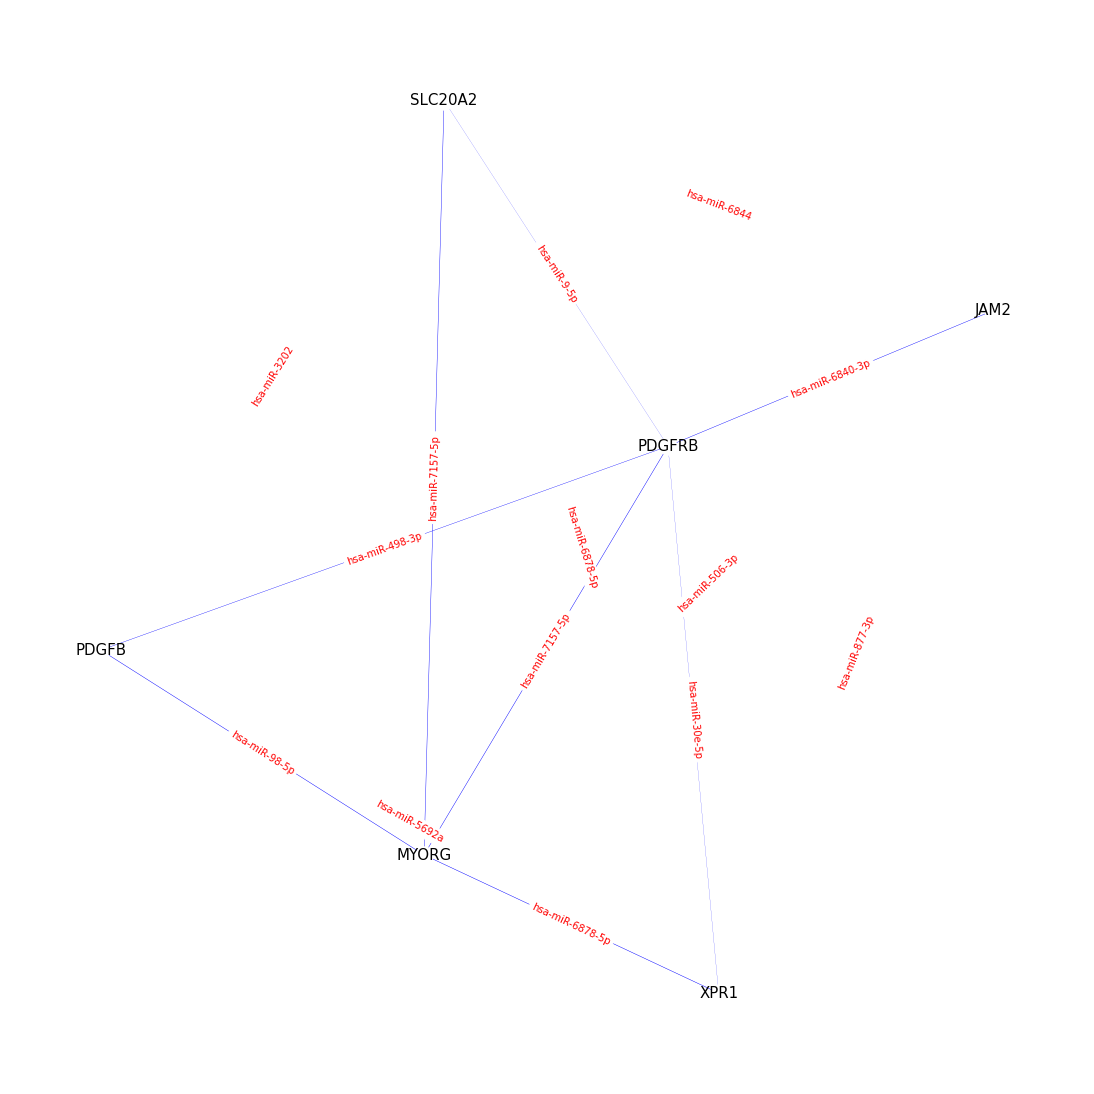

In [81]:
weights = [np.log2(pfbc_graph[u][v]['target_value']/100) for u,v in pfbc_graph.edges]
edge_labels = {(u, v): pfbc_graph[u][v]['mirna'] for u,v in pfbc_graph.edges}

pos = nx.spring_layout(pfbc_graph)

plt.figure(figsize =(15, 15))
nx.draw(pfbc_graph, pos=pos,
        node_color = 'white', width = weights, edge_color = 'blue', with_labels=True, font_color='black', font_size=15)
nx.draw_networkx_edge_labels(
    pfbc_graph, pos=pos, edge_labels=edge_labels,
    font_color='red'
)
#plt.savefig('figure/pfbc_network_2.png')
plt.show()

In [82]:
edge_labels

{('JAM2', 'MYORG'): 'hsa-miR-506-3p',
 ('JAM2', 'PDGFRB'): 'hsa-miR-6840-3p',
 ('JAM2', 'XPR1'): 'hsa-miR-877-3p',
 ('JAM2', 'SLC20A2'): 'hsa-miR-6844',
 ('MYORG', 'SLC20A2'): 'hsa-miR-7157-5p',
 ('MYORG', 'PDGFRB'): 'hsa-miR-7157-5p',
 ('MYORG', 'XPR1'): 'hsa-miR-6878-5p',
 ('MYORG', 'PDGFB'): 'hsa-miR-98-5p',
 ('SLC20A2', 'XPR1'): 'hsa-miR-6878-5p',
 ('SLC20A2', 'PDGFRB'): 'hsa-miR-9-5p',
 ('SLC20A2', 'PDGFB'): 'hsa-miR-3202',
 ('XPR1', 'PDGFRB'): 'hsa-miR-30e-5p',
 ('XPR1', 'PDGFB'): 'hsa-miR-5692a',
 ('PDGFRB', 'PDGFB'): 'hsa-miR-498-3p'}

#### Drawing a six-venn diagram

In [83]:
from venn import venn, get_labels

<AxesSubplot:>

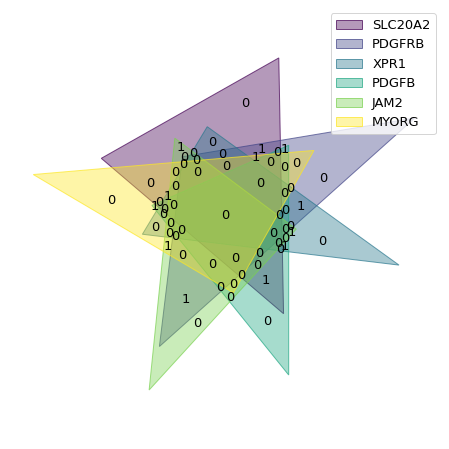

In [84]:
dataset_dict = {}
for gene in PFBC_GENES:
    dataset_dict[gene] = set(pfbc_mirna_df[pfbc_mirna_df['g1'] == gene]['mirna'].values)

venn(dataset_dict)

<AxesSubplot:>

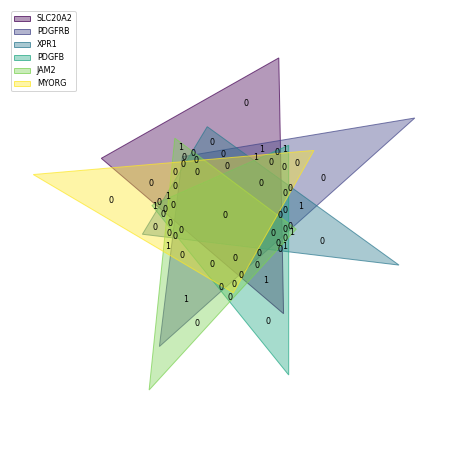

In [85]:
pfbc_mirna_df
dataset_dict = {}
for gene in PFBC_GENES:
    dataset_dict[gene] = set(pfbc_mirna_df[pfbc_mirna_df['g1'] == gene]['mirna'].values)

venn(dataset_dict, fontsize=8, legend_loc="upper left")

#### 4.4.2 mirGraph's shortest paths for all PFBC genes

In [86]:
path_sources_mir = {}
for gene in PFBC_GENES:
    full_paths = []
    full_length = 0
    queue = PFBC_GENES.copy()
    while len(queue) > 0:
        try:
            nearest_step, length, path = get_nearest(mir_graph, gene, queue, 'target_value')
            full_paths.extend(path)
            full_length += length
            queue.remove(nearest_step)     
        except TypeError:
            break
    
    path_sources_mir[gene] = (full_length, full_paths)

path_sources_mir[min(path_sources, key=path_sources.get)]

(2.12037465132,
 ['SLC20A2',
  'CDKL5',
  'GNAQ',
  'LDB2',
  'XPR1',
  'SLC20A2',
  'CDKL5',
  'GNAQ',
  'FARP2',
  'PDGFRB',
  'SLC20A2',
  'CDKL5',
  'CXCL12',
  'EMCN',
  'GNA14',
  'PDGFB',
  'SLC20A2',
  'CDKL5',
  'GNAQ',
  'LDB2',
  'PVR',
  'FYN',
  'JAM2',
  'SLC20A2',
  'MYORG'])

In [87]:
close_centrality = nx.closeness_centrality(mir_graph)
bet_centrality = nx.betweenness_centrality(mir_graph, normalized = True, 
                                              endpoints = False)
deg_centrality = nx.degree_centrality(mir_graph)

central_measures = pd.DataFrame()
central_measures['gene'] = bet_centrality.keys()
central_measures['betweenness'] = [val for val in bet_centrality.values()]
central_measures['degree'] = [val for val in deg_centrality.values()]
central_measures['closeness'] = [val for val in close_centrality.values()]

ranked = central_measures.sort_values(
    by='betweenness', ascending=False
    ).reset_index().drop('index', axis = 1)

ranked

gene  betweenness    degree  closeness
0        GNAI3     0.008922  0.914286   0.921053
1        NTNG1     0.007063  0.952381   0.954545
2         IGF1     0.006933  0.961905   0.963303
3         LRP6     0.006382  0.942857   0.945946
4         AKT3     0.005461  0.961905   0.963303
5        MAPK1     0.005202  0.933333   0.937500
6        ITGAV     0.005065  0.942857   0.945946
7        GNAO1     0.004849  0.885714   0.897436
8       LHFPL6     0.004846  0.857143   0.875000
9       PIK3R1     0.004777  0.952381   0.954545
10        RHOA     0.004669  0.885714   0.897436
11     KHDRBS1     0.004563  0.923810   0.929204
12       MEIS1     0.004479  0.780952   0.820312
13        LDB2     0.004421  0.819048   0.846774
14       GNA13     0.004388  0.933333   0.937500
15         SHB     0.003996  0.847619   0.867769
16        PTEN     0.003992  0.933333   0.937500
17        JCAD     0.003936  0.923810   0.929204
18       VEGFA     0.003871  0.923810   0.929204
19        XPR1     0.003865  0.914286   0.921053
20      PIK3CA     0.003804  0.933333   0.937500
21        AFDN     0.003781  0.914286   0.921053
22       PDGFB     0.003644  0.800000   0.833333
23        RHOJ     0.003596  0.838095   0.860656
24        JAK2     0.003408  0.828571   0.853659
25       GNAI1     0.003379  0.895238   0.905172
26        VAV2     0.003322  0.857143   0.875000
27     RAPGEF1     0.003293  0.904762   0.913043
28      COL1A1     0.003234  0.876190   0.889831
29        GNAQ     0.003227  0.904762   0.913043
30       MYORG     0.003191  0.866667   0.882353
31     SLC17A2     0.003095  0.704762   0.772059
32      CXCL12     0.003051  0.904762   0.913043
33       PTGS2     0.003041  0.876190   0.889831
34         SRC     0.002996  0.771429   0.813953
35       ABCC1     0.002989  0.809524   0.840000
36         FYN     0.002973  0.857143   0.875000
37      COL1A2     0.002972  0.771429   0.813953
38        FLT1     0.002874  0.895238   0.905172
39        JAM2     0.002822  0.819048   0.846774
40       RASA1     0.002821  0.885714   0.897436
41      PDGFRA     0.002813  0.876190   0.889831
42     TNFSF11     0.002795  0.838095   0.860656
43       CDKL5     0.002780  0.885714   0.897436
44       GNAI2     0.002753  0.800000   0.833333
45      PDGFRB     0.002505  0.790476   0.826772
46        GPC4     0.002450  0.866667   0.882353
47        GNAZ     0.002380  0.742857   0.795455
48         DCN     0.002353  0.828571   0.853659
49       S1PR1     0.002248  0.828571   0.853659
50         CRK     0.002197  0.838095   0.860656
51        GRB2     0.002173  0.847619   0.867769
52       ITGB3     0.002115  0.733333   0.789474
53      PTPN11     0.002056  0.876190   0.889831
54        TLN1     0.002020  0.771429   0.813953
55       S1PR3     0.002009  0.780952   0.820312
56        RAC1     0.001991  0.733333   0.789474
57         KDR     0.001936  0.847619   0.867769
58       GNA14     0.001931  0.800000   0.833333
59       IL1R1     0.001925  0.838095   0.860656
60   TNFRSF11B     0.001914  0.838095   0.860656
61       PDGFC     0.001900  0.733333   0.789474
62       CDC27     0.001875  0.838095   0.860656
63       GNA12     0.001793  0.742857   0.795455
64     SLC20A2     0.001698  0.800000   0.833333
65        EMCN     0.001571  0.800000   0.833333
66       PDGFA     0.001531  0.780952   0.820312
67      IQGAP1     0.001440  0.800000   0.833333
68       CXCR4     0.001434  0.733333   0.789474
69       SPARC     0.001416  0.733333   0.789474
70         PVR     0.001411  0.771429   0.813953
71     NECTIN2     0.001345  0.704762   0.772059
72       GNA11     0.001345  0.742857   0.795455
73       MFAP4     0.001344  0.580952   0.704698
74       PDGFD     0.001340  0.809524   0.840000
75        F11R     0.001338  0.714286   0.777778
76       SH2B1     0.001326  0.571429   0.700000
77       PTPRM     0.001278  0.780952   0.820312
78        IBSP     0.001213  0.676190   0.755396
79        JAK3     0.001203  0.657143   0.744681
80       LAMA4     0.001177  0.742857   0

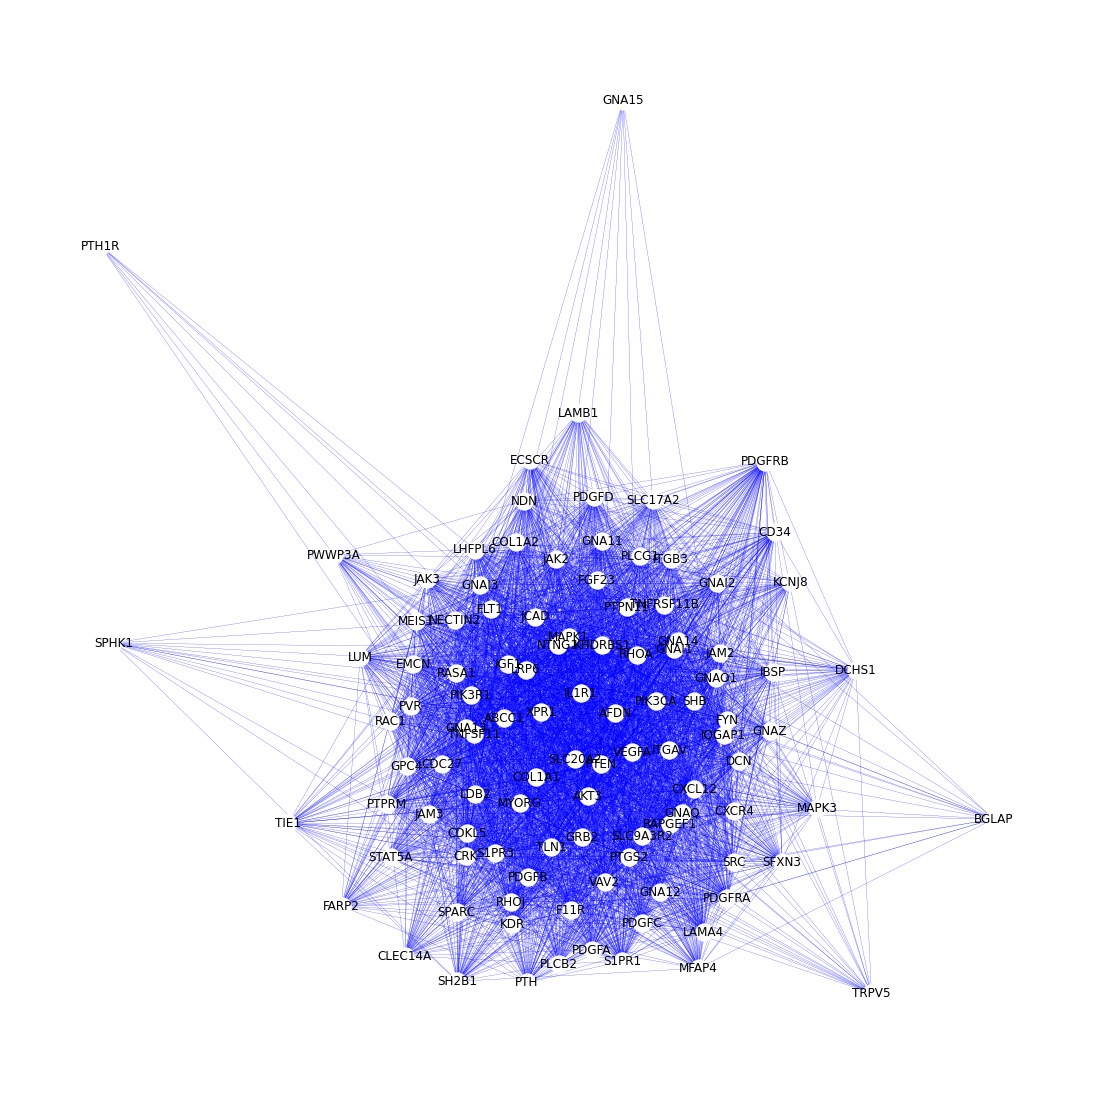

In [88]:
plt.figure(figsize =(15, 15))
nx.draw(mir_graph, node_color = 'white', edge_color = 'blue', width=0.2, with_labels=True, font_color='black')
plt.show()

In [89]:
node_list = ['SLC20A2',
  'CDKL5',
  'GNAQ',
  'LDB2',
  'XPR1',
  'SLC20A2',
  'CDKL5',
  'GNAQ',
  'FARP2',
  'PDGFRB',
  'SLC20A2',
  'CDKL5',
  'CXCL12',
  'EMCN',
  'GNA14',
  'PDGFB',
  'SLC20A2',
  'CDKL5',
  'GNAQ',
  'LDB2',
  'PVR',
  'FYN',
  'JAM2',
  'SLC20A2',
  'MYORG']

short_net = mir_graph.subgraph(nodes = node_list)
edges = []
for i in range(len(node_list) - 1):
    edges.append((node_list[i], node_list[i+1]))
edges


[('SLC20A2', 'CDKL5'),
 ('CDKL5', 'GNAQ'),
 ('GNAQ', 'LDB2'),
 ('LDB2', 'XPR1'),
 ('XPR1', 'SLC20A2'),
 ('SLC20A2', 'CDKL5'),
 ('CDKL5', 'GNAQ'),
 ('GNAQ', 'FARP2'),
 ('FARP2', 'PDGFRB'),
 ('PDGFRB', 'SLC20A2'),
 ('SLC20A2', 'CDKL5'),
 ('CDKL5', 'CXCL12'),
 ('CXCL12', 'EMCN'),
 ('EMCN', 'GNA14'),
 ('GNA14', 'PDGFB'),
 ('PDGFB', 'SLC20A2'),
 ('SLC20A2', 'CDKL5'),
 ('CDKL5', 'GNAQ'),
 ('GNAQ', 'LDB2'),
 ('LDB2', 'PVR'),
 ('PVR', 'FYN'),
 ('FYN', 'JAM2'),
 ('JAM2', 'SLC20A2'),
 ('SLC20A2', 'MYORG')]

In [90]:
short_graph = nx.create_empty_copy(short_net)

In [91]:
short_graph.add_edges_from(edges)
short_graph.edges()

EdgeView([('CDKL5', 'SLC20A2'), ('CDKL5', 'GNAQ'), ('CDKL5', 'CXCL12'), ('JAM2', 'FYN'), ('JAM2', 'SLC20A2'), ('CXCL12', 'EMCN'), ('GNA14', 'EMCN'), ('GNA14', 'PDGFB'), ('FYN', 'PVR'), ('GNAQ', 'LDB2'), ('GNAQ', 'FARP2'), ('PDGFB', 'SLC20A2'), ('MYORG', 'SLC20A2'), ('SLC20A2', 'XPR1'), ('SLC20A2', 'PDGFRB'), ('PVR', 'LDB2'), ('LDB2', 'XPR1'), ('PDGFRB', 'FARP2')])

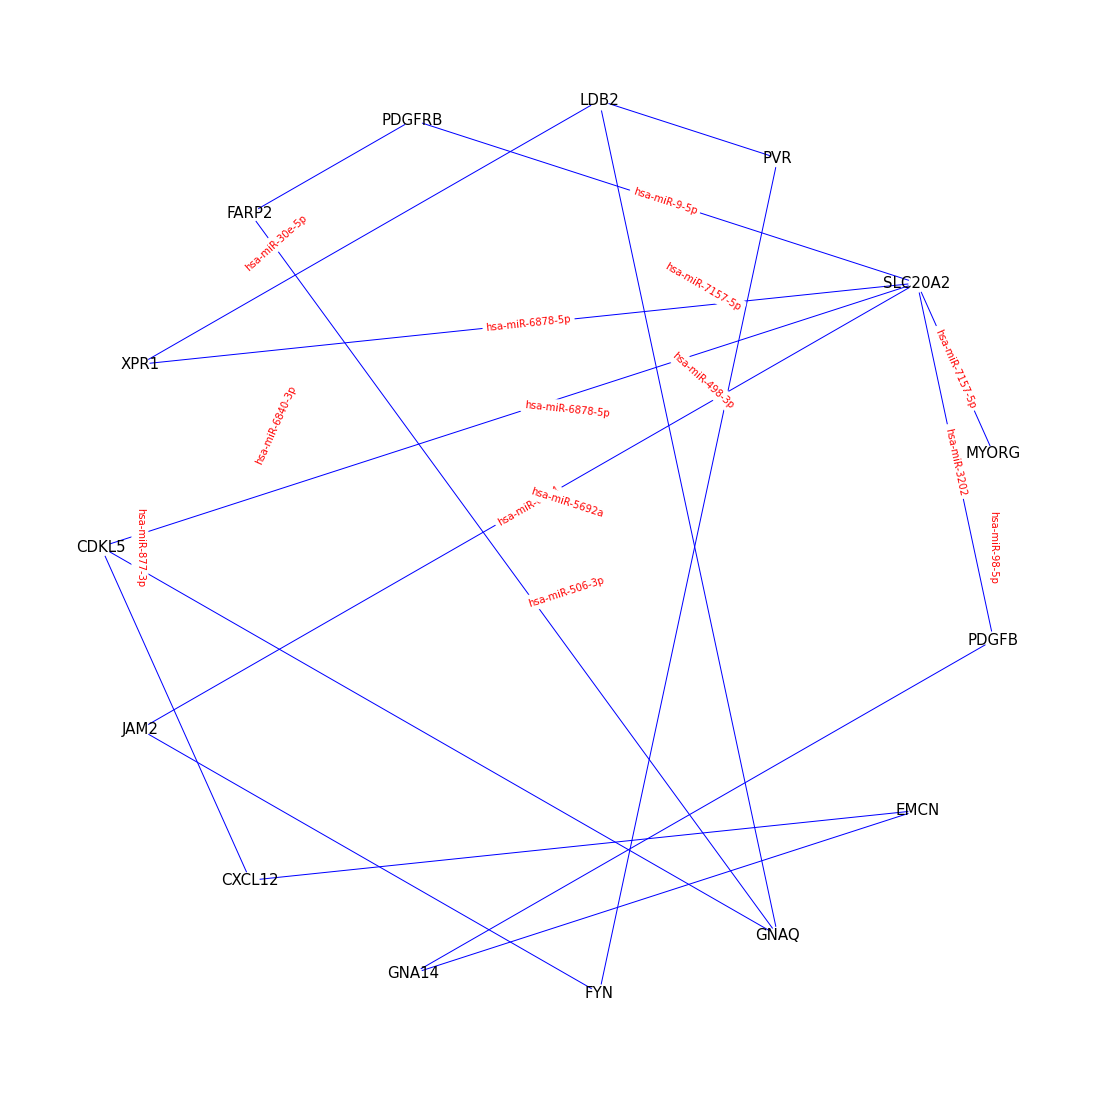

In [92]:
pos = nx.shell_layout(short_graph)

plt.figure(figsize =(15, 15))
nx.draw(short_graph, pos=pos,
        node_color = 'white', edge_color = 'blue', with_labels=True, font_color='black', font_size=15)
nx.draw_networkx_edge_labels(
    short_graph, pos=pos, edge_labels=edge_labels,
    font_color='red'
)
#plt.savefig('figure/shortestpath_network.png')
plt.show()

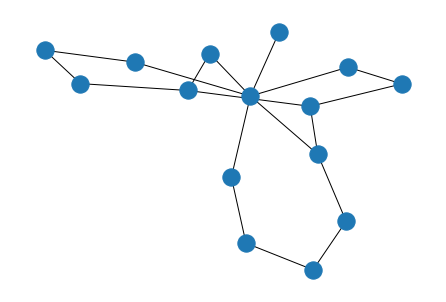

In [93]:
pos = nx.spring_layout(short_graph)  # Seed layout for reproducibility
nx.draw(short_graph, pos=pos)
plt.show()

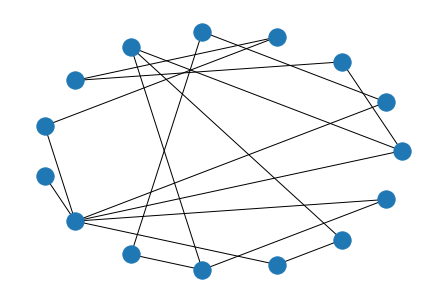

In [94]:
nx.draw_circular(short_graph)

In [95]:
pos = graphviz_layout(short_graph)
plt.figure(figsize =(15, 15))
nx.draw(short_graph, pos=pos,
        node_color = 'white', edge_color = 'blue', with_labels=True, font_color='black', font_size=15)
plt.show()

NameError: name 'graphviz_layout' is not defined

### Similarity analysis

In [ ]:
mir_graph_ged_gen = nx.optimize_graph_edit_distance(mir_graph, mir_graph_target)

In [ ]:
print(next(mir_graph_ged_gen))

In [ ]:
genemania_graph_ged_gen = nx.optimize_graph_edit_distance(graph, mir_graph)
print(next(genemania_graph_ged_gen))

### Panther similarity

In [ ]:
panther_dict = {}
for gene in PFBC_GENES:
    panther_dict[f'{gene}_genemania'] = nx.panther_similarity(graph, source=gene, path_length = 50, k=10)
    panther_dict[f'{gene}_joint'] = nx.panther_similarity(mir_graph, source=gene, path_length = 50, k=10)

In [ ]:
genemania_panther = ([list(gene) for gene in (panther_dict[source].keys() for source in panther_dict.keys() if source.endswith('_genemania'))])
joint_panther = ([list(gene) for gene in (panther_dict[source].keys() for source in panther_dict.keys() if source.endswith('_joint'))])

In [ ]:
set([item for sublist in genemania_panther for item in sublist])

In [ ]:
set([item for sublist in joint_panther for item in sublist])

In [ ]:
proximity = nx.graph_edit_distance(graph, mir_graph)

In [ ]:
proximity

In [ ]:
print('a')